In [1]:
import os
import sys
sys.path.insert(0, '../python_scripts')
import h_gen,meta
from meta import *
from h_gen import *


Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [2]:
metadata = meta.create_metadata()

['../JSONS/alb_labels.json', '../JSONS/bet_labels.json', '../JSONS/dol_labels.json', '../JSONS/lag_labels.json', '../JSONS/other_labels.json', '../JSONS/shark_labels.json', '../JSONS/yft_labels.json']



{'class': 'YFT', 'code': 7, 'rectangles': [{'height': 148.4292760879743, 'x': 651.9013805783834, 'y': 478.5359861076293, 'width': 274.2973022105765}], 'width': 1280, 'filename': 'img_07233.jpg', 'height': 974, 'path': '../train/train/YFT/img_07233.jpg'}


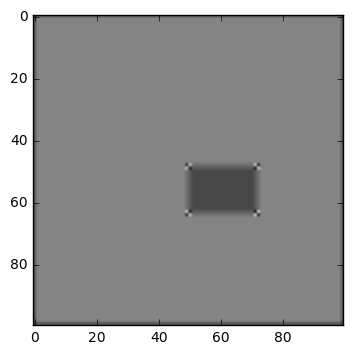

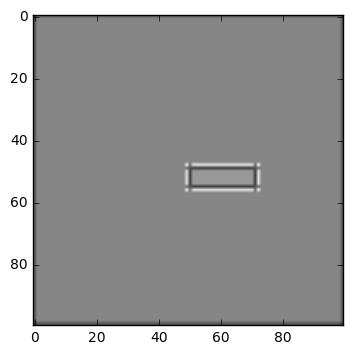

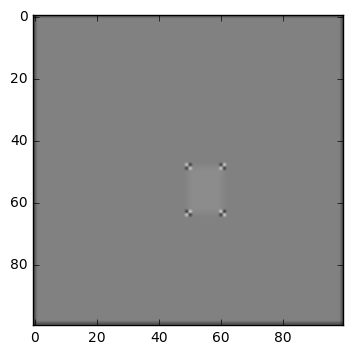

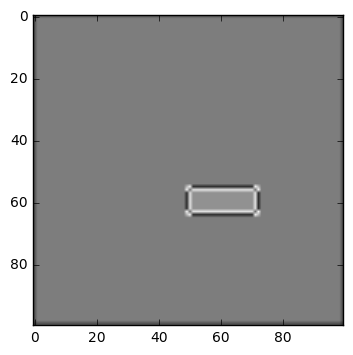

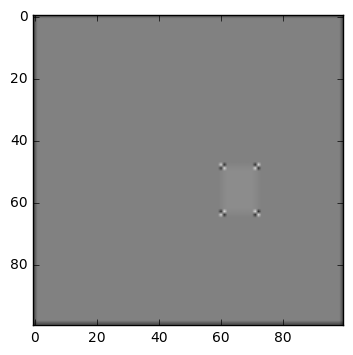

{'class': 'DOL', 'code': 4, 'rectangles': [{'height': 149.46000000000032, 'x': 205.86000000000044, 'y': 358.1400000000008, 'width': 294.6900000000006}], 'width': 1280, 'filename': 'img_01776.jpg', 'height': 750, 'path': '../train/train/DOL/img_01776.jpg'}


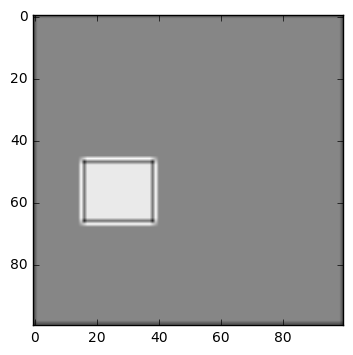

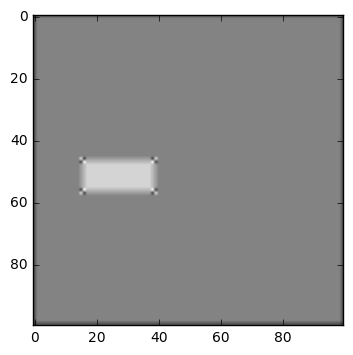

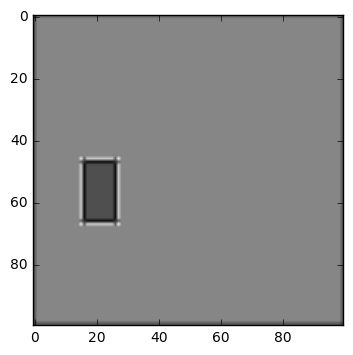

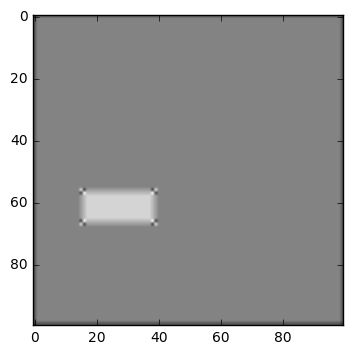

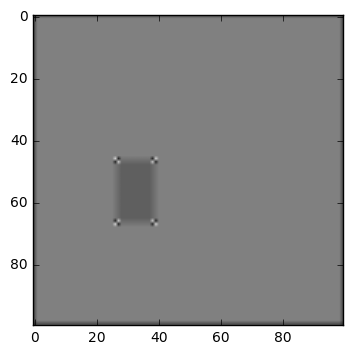

{'class': 'OTHER', 'code': 1, 'rectangles': [{'height': 181.0, 'x': 537.0, 'y': 346.0, 'width': 64.0}, {'height': 199.0, 'x': 128.0, 'y': 486.0, 'width': 66.0}], 'width': 1280, 'filename': 'img_00472.jpg', 'height': 720, 'path': '../train/train/OTHER/img_00472.jpg'}


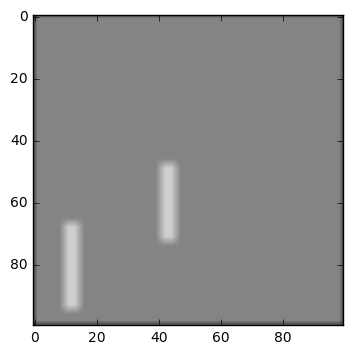

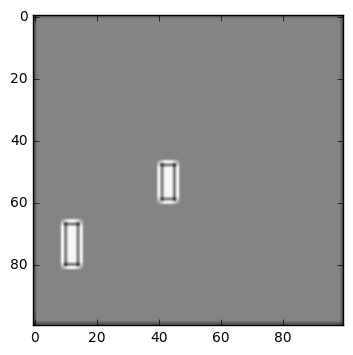

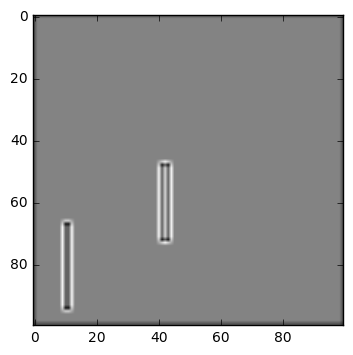

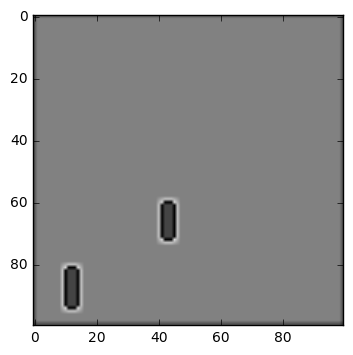

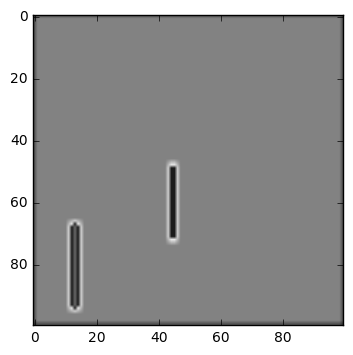

In [3]:
count = 0
for i in tq(metadata):
    print(metadata[i])
    masks,w_masks = h_gen.get_5_masks_w(metadata[i],option=1)
    plot_5_masks(w_masks)
    if count > 1:
        break
    count+=1

In [473]:
def get_weights(mask,rects,i,Secu,x_r,y_r,opt=0):
    mask_size = mask.shape
    surf = mask_size[0]*mask_size[1]
    SUM = mask.sum()
    mask_weights = np.zeros(mask_size[::-1])
    mask_weights2 = np.zeros(mask_size[::-1])
    act_surf = 0
    for rect in rects:
        x = rect['x']*x_r
        y = rect['y']*y_r
        w = rect['width']*x_r
        h = rect['height']*y_r
        if i == 0:
            act_surf += h*w
        if i == 1:
            act_surf += (h/2)*w
        if i == 2:
            act_surf += h*(w/2)
        if i == 3:
            act_surf += (h/2)*w 
        if i == 4:
            act_surf += h*(w/2)           
    surf = surf - act_surf
    for rect in rects:
        x = rect['x']*x_r
        y = rect['y']*y_r
        w = rect['width']*x_r
        h = rect['height']*y_r
        if opt == 0: # DIRAC
            mask_weights[np.where(mask == 1)] = surf/act_surf
            mask_weights[np.where(mask == 0)] = 1
            return mask_weights/mask_weights.max()
        elif opt == 1: # DIRAC
            mask_weights[np.where(mask == 1)] = surf/act_surf
            mask_weights[np.where(mask == 0)] = 1
            mask_weights = mask_weights/mask_weights.max()
            mask_weights = scipy.signal.convolve2d(mask_weights,np.ones((3,3))/9,mode='same')
            return mask_weights*10000/mask_weights.sum()
        

def get_5_masks_w(metadata, mask_size=(100,100),Secu=5,option=0):
    import math
    """ Get the mask of a given image. Save the results
        in the "mask" folder in case the function is 
        called again."""
    masks = np.zeros((5,mask_size[0],mask_size[1]))
    w_masks = np.zeros((5,mask_size[0],mask_size[1]))
    size = (metadata["width"], metadata["height"])
    try:
        rects = metadata['rectangles']
    except KeyError:
        if metadata["class"] == "NoF":
            rects = []
        else:
            print('here')
            return None
    mask = np.zeros(mask_size[::-1])
    if len(rects) > 0 :
        x_r = mask_size[0]/size[0]
        y_r = mask_size[1]/size[1]
        for rect in rects:
            x = rect['x']*x_r
            y = rect['y']*y_r
            w = rect['width']*x_r
            h = rect['height']*y_r
            X = math.floor(x)
            X2 = math.floor(x+w)
            Y = math.floor(y)
            Y2 = math.floor(y+h)
            mask[Y:Y2,X:X2] = 1

        #save(mask,file)
        w_masks[0] = get_weights(mask,rects,0,Secu,x_r,y_r,option)
        masks[0] = mask
        for i in range(1,5):
            mask = np.zeros(mask_size[::-1])
            x_r = mask_size[0]/size[0]
            y_r = mask_size[1]/size[1]
            for rect in rects:
                x = rect['x']*x_r
                y = rect['y']*y_r
                w = rect['width']*x_r
                h = rect['height']*y_r
                if i == 1: # bottom
                    X = math.floor(x)
                    X2 = math.floor(x+w)
                    Y = math.floor(y)
                    Y2 = math.floor(y+h/2)
                    mask[Y:Y2,X:X2] = 1
                elif i == 2: # left
                    X = math.floor(x)
                    X2 = math.floor(x+w/2)
                    Y = math.floor(y)
                    Y2 = math.floor(y+h)                        
                    mask[Y:Y2,X:X2] = 1
                elif i  == 3: # top
                    X = math.floor(x)
                    X2 = math.floor(x+w)
                    Y = math.floor(y+h/2)
                    Y2 = math.floor(y+h)                           
                    mask[Y:Y2,X:X2] = 1
                elif i == 4: # right
                    X = math.floor(x+w/2)
                    X2 = math.floor(x+w)
                    Y = math.floor(y)
                    Y2 = math.floor(y+h)                           
                    mask[Y:Y2,X:X2] = 1
            #save(mask,filei)
            w_masks[i] = get_weights(mask,rects,i,Secu,x_r,y_r,option)
            masks[i] = mask
    else:
        #save(mask,file)
         for i in range(1,5):
            masks[i]=mask
    masks = np.array(masks)
    w_masks = np.array(w_masks)
    return masks,w_masks
def expand_mask_to_img(mask):
    mask = np.tile(mask,(3,1,1))
    return np.rollaxis(mask,0,3)
def plot_img(img):
    plt.figure()
    plt.imshow(img)
    plt.show()
def plot_5_masks(masks):
    for mask in masks.tolist():
        mask_img = expand_mask_to_img(np.array(mask))
        plot_img(mask_img)    

{'class': 'YFT', 'code': 7, 'rectangles': [{'height': 148.4292760879743, 'x': 651.9013805783834, 'y': 478.5359861076293, 'width': 274.2973022105765}], 'width': 1280, 'filename': 'img_07233.jpg', 'height': 974, 'path': '../train/train/YFT/img_07233.jpg'}


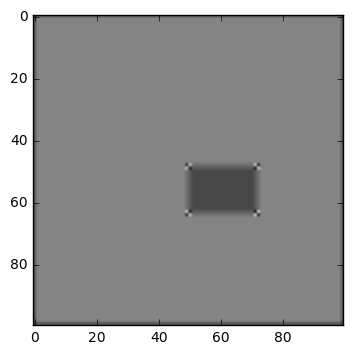

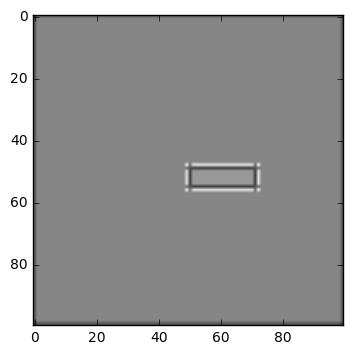

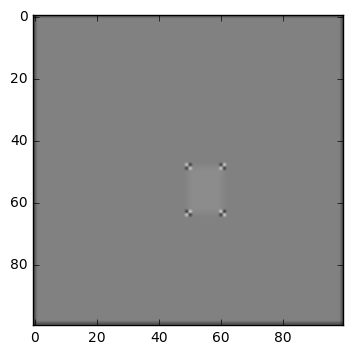

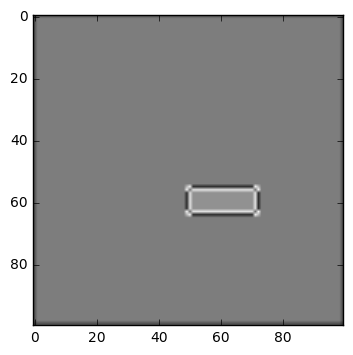

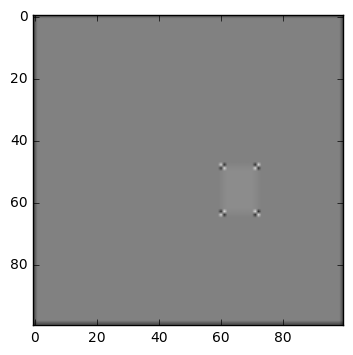

{'class': 'DOL', 'code': 4, 'rectangles': [{'height': 149.46000000000032, 'x': 205.86000000000044, 'y': 358.1400000000008, 'width': 294.6900000000006}], 'width': 1280, 'filename': 'img_01776.jpg', 'height': 750, 'path': '../train/train/DOL/img_01776.jpg'}


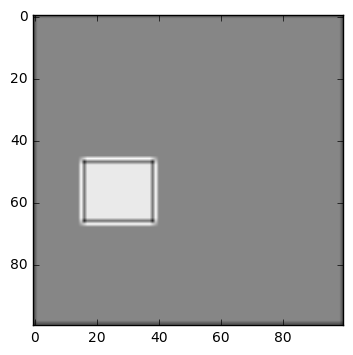

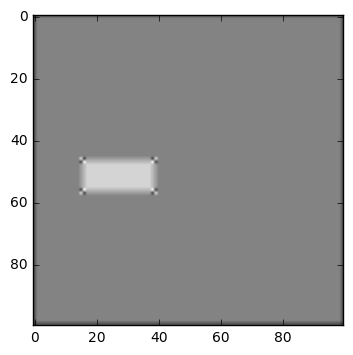

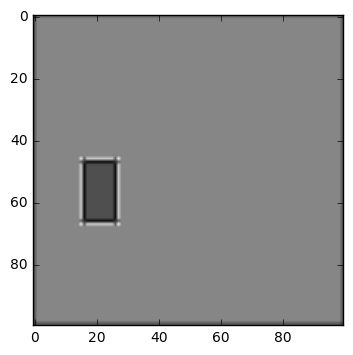

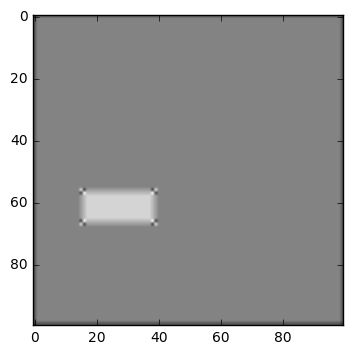

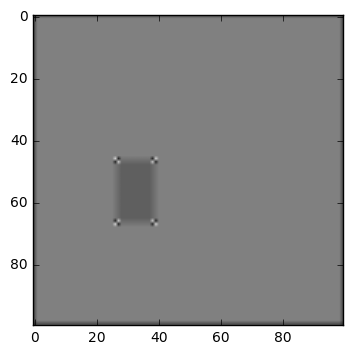

{'class': 'OTHER', 'code': 1, 'rectangles': [{'height': 181.0, 'x': 537.0, 'y': 346.0, 'width': 64.0}, {'height': 199.0, 'x': 128.0, 'y': 486.0, 'width': 66.0}], 'width': 1280, 'filename': 'img_00472.jpg', 'height': 720, 'path': '../train/train/OTHER/img_00472.jpg'}


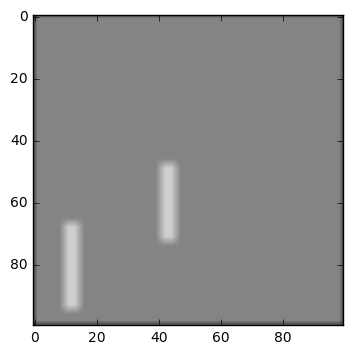

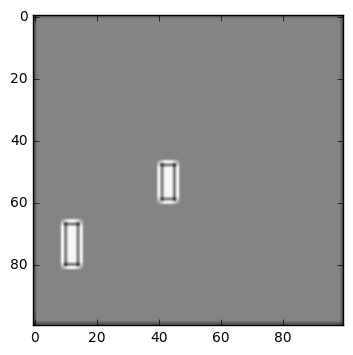

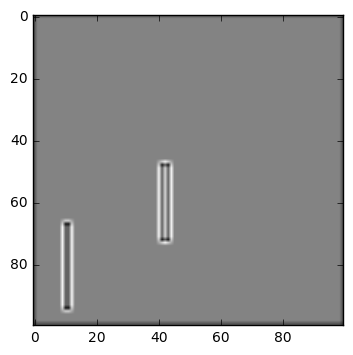

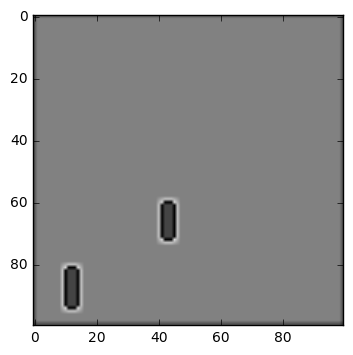

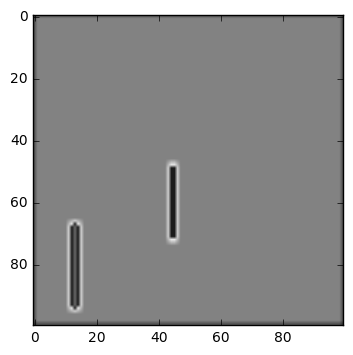

In [474]:
count = 0
for i in tq(metadata):
    print(metadata[i])
    masks,w_masks = get_5_masks_w(metadata[i],option=1)
    plot_5_masks(w_masks)
    if count > 1:
        break
    count+=1

<h1> FIND RECTS FROM MASK </h1>

In [2]:
heatmaps_fake = '../heatmaps/png/ResNet50/'
transformations = os.listdir(heatmaps_fake)
data_fake = [[{'direct':heatmaps_fake+tf+'/'+cl,'names':os.listdir(heatmaps_fake+tf+'/'+cl)} for cl in os.listdir(heatmaps_fake+tf)] for tf in transformations]

In [4]:
ALB_fake = [data_fake[i][0] for i in range(6)]

In [5]:
import collections
alb_co = collections.defaultdict(list)
for obj in ALB_fake:
    direct = obj['direct']
    print(direct)
    for name in obj['names']:
        if len(alb_co[name]) <= 4:
            alb_co[name].append(direct+'/'+name)

../heatmaps/png/ResNet50/horizontal flip/ALB
../heatmaps/png/ResNet50/identity/ALB
../heatmaps/png/ResNet50/resolution 25 down/ALB
../heatmaps/png/ResNet50/resolution 25 up/ALB
../heatmaps/png/ResNet50/rotate 15/ALB
../heatmaps/png/ResNet50/vertical flip/ALB


In [6]:
keys = [key for key in alb_co.keys()]
N = 10
from keras.preprocessing.image import load_img, img_to_array, random_rotation, flip_axis, array_to_img
#final_data = np.expand_dims(np.array([[img_to_array(load_img(f)) for f in alb_co[key]] for key in keys[:N]]).mean(axis=2),axis=2)
final_data = np.array([[img_to_array(load_img(f)) for f in alb_co[key]] for key in keys[:N]])

In [7]:
final_data.shape

(10, 5, 3, 100, 100)

In [8]:
def change_class(value, old, new):
    if value == old:
        return new
    else:
        return value
np_change_class = np.vectorize(change_class)




def stuff(mat,i,j,islands_list, count, islands_matrix):
    if mat[i][j] == 0:
        pass
    else:
        before = int(islands_matrix[i][j-1])
        above = int(islands_matrix[i-1][j])
        if before == 0:
            if  above== 0:
                islands_matrix[i][j] = count
                count +=1
                islands_list.append([(j,i)])
            else: 
                islands_matrix[i][j] = above
                islands_list[above-1].append((j,i))
        
        else:
            if above == 0:
                islands_matrix[i][j] = before
                islands_list[before-1].append((j,i))
            
            
            else:
                if above == before:
                    islands_matrix[i][j] = before
                    islands_list[before-1].append((j,i))
                
                #it's on.
                else:
                    old = max((above,before))
                    new = min((above,before))
                    
                    islands_matrix[i][j] = new
                    islands_matrix = np_change_class(islands_matrix, old, new)
                    islands_list[new-1] += islands_list[old-1]
                    islands_list[new-1].append((j,i))
                    islands_list[old-1] = []
                    
    return islands_list, count, islands_matrix        


# The not fun part
def group_by_island(matrix):
    
    h, l = np.shape(matrix)
    border = np.array([[0]*(l)])
    mat = np.concatenate((border,matrix), axis=0)
    border = np.array([[0]*(h+1)])
    mat = np.concatenate((border.T, mat), axis=1)
    
    islands_matrix =np.zeros((h+1,l+1))
    count = 1
    islands_list = []
    
    for i in range(1,h+1):
        for j in range(1, l+1):
            islands_list, count, islands_matrix = stuff(mat,i,j,islands_list, count, islands_matrix)

    
    
    return islands_matrix, islands_list
def binarize(value, threshold,state=True):
    if state:
        if value < threshold:
            return 255
        else:
            return 0
    else:
        if value < threshold:
            return 0
        else:
            return 255        
def filter_mask(img,heatmap,th,state):
    np_binarize = np.vectorize(binarize)
    bb = np_binarize(heatmap, th,state)
    import scipy
    size = np.array(img.size)
    b = scipy.misc.imresize(bb, [size[1],size[0]], interp='bicubic', mode=None)
    img_array = np.array(img)
    bb = b >= 2
    mask = np.zeros_like(img_array)
    for i in range(3):
        mask[:,:,i] = bb
    idx=(mask==0)
    img_array[idx]=mask[idx]
    img_filter = Image.fromarray(img_array)
    return img_filter,Image.fromarray(b)

In [13]:
def closest_point(center,a,b):
    import math
    if math.fabs(a-center) > math.fabs(b - center):
        return b
    else:
        return a
def farest_point(center,a,b):
    import math
    if math.fabs(a-center) > math.fabs(b - center):
        return a
    else:
        return b
def distance_euclidian(v,w):
    import math
    if len(v) == len(w):
        l = 0
        for i in range(len(v)):
            l += math.pow(w[i]-v[i],2)
        return math.sqrt(l)
    else:
        return -1
def find_extremes(list_coordinates):
    max_x = max(list_coordinates, key = lambda x: x[0])[0]
    min_x = min(list_coordinates, key = lambda x: x[0])[0]
    max_y = max(list_coordinates, key = lambda x: x[1])[1]
    min_y = min(list_coordinates, key = lambda x: x[1])[1]
    center = np.array([i[0] for i in list_coordinates]).mean(),np.array([ i[1] for i in list_coordinates]).mean()
    a = closest_point(center[0],max_x+1,min_x - 1)
    b = closest_point(center[1],max_y+1,min_y - 1)  
    vector = []
    if a == max_x+1 and b == max_y+1:
        dist_x = max_x+1-center[0]
        dist_y = max_y+1-center[1]        
        vector.append([center[0]-dist_x,center[1]-dist_y,max_x+1,max_y+1])
        
    elif a == max_x+1 and b == min_y - 1:
        dist_x = max_x+1-center[0]
        dist_y = center[1]-min_y + 1        
        vector.append([center[0]-dist_x,min_y - 1,max_x+1,min_y - 1+dist_y*2]) 
        
    elif a == min_x - 1 and b == min_y - 1:
        dist_x = center[0]-min_x + 1
        dist_y = center[1]-min_y + 1      
        vector.append([min_x - 1,min_y - 1,min_x - 1+dist_x*2,min_y - 1+dist_y*2])  
        
    elif a == min_x - 1 and b == max_y+1:
        dist_x = center[0]-min_x + 1
        dist_y = max_y+1-center[1]        
        vector.append([min_x - 1,center[1]-dist_y,min_x - 1+dist_x*2,max_y+1])
    vector = np.array(vector)
    vector[np.where(vector<0)]=0
    vector = vector[0].tolist()

    a = farest_point(center[0],max_x+1,min_x - 1)
    b = farest_point(center[1],max_y+1,min_y - 1)  
    vector2 = []
    if a == max_x+1 and b == max_y+1:
        dist_x = max_x+1-center[0]
        dist_y = max_y+1-center[1]        
        vector2.append([center[0]-dist_x,center[1]-dist_y,max_x+1,max_y+1])
        
    elif a == max_x+1 and b == min_y - 1:
        dist_x = max_x+1-center[0]
        dist_y = center[1]-min_y + 1        
        vector2.append([center[0]-dist_x,center[1]-dist_y,max_x+1,max_y+1]) 
        
    elif a == min_x - 1 and b == min_y - 1:
        dist_x = center[0]-min_x + 1
        dist_y = center[1]-min_y + 1      
        vector2.append([min_x - 1,min_y - 1,min_x - 1+dist_x*2,min_y - 1+dist_y*2]) 
        
    elif a == min_x - 1 and b == max_y+1:
        dist_x = center[0]-min_x + 1
        dist_y = max_y+1-center[1]        
        vector2.append([min_x - 1,center[1]-dist_y,min_x - 1+dist_x*2,max_y+1])
    vector2 = np.array(vector2)
    vector2[np.where(vector2<0)]=0

    vector2 = vector2[0].tolist()
    w = [min_x - 1, min_y - 1, max_x+1, max_y + 1]
    return w,vector#,vector2

def get_rectangles(islands_list, area_limit=4):
    list_coordinates = []
    for island in islands_list:
        if len(island) == 0:
            continue
        else:
            coordinates = find_extremes(island)
            #print(coordinates)
            #print(coordinates[2]*coordinates[3])
            if coordinates[0][2]*coordinates[0][3] >=area_limit:
                #print(coordinates)
                list_coordinates.append(coordinates)
    return list_coordinates
    
def rescale01(img):
    img = img - img.min()
    return img/img.max()
def rescale_11(img):
    img = img-img.mean(axis=0)
    return img/img.max(axis=0)
def detect_rects(masks):
    from scipy import ndimage
    import math
    alphas = [0.9 for i in range(5)]
    rects = []
    for i in range(5):
        m = np.rollaxis(masks[i],0,3)
        plt.figure()
        plt.imshow(m.mean(axis=2))
        m_mask = np.zeros_like(masks[i])
        m_mask[np.where(masks[i]==255)] = 255
        mm = np.rollaxis(m_mask,0,3)
        mm[:,:,2]=0
        mm[np.where(mm[:,:,1]!=0)]=255
        mm[np.where(mm[:,:,0]!=0)]=255
        mm[:,:,0]=0
        plt.figure()
        plt.title("dd")
        plt.imshow(rescale01(mm.mean(axis=2)))
        final_heat = mm.mean(axis=2)
        plt.figure()
        image_1 = ndimage.binary_dilation(final_heat)
        plt.figure()
        plt.imshow(image_1)
        plt.show()
        plt.figure()
        islands_matrix, islands_list = group_by_island(image_1)
        plt.imshow(islands_matrix, interpolation='none')
        plt.show()
        rects.append(get_rectangles(islands_list))
    return rects
def bounding_box(X):
    Min = X.min(axis=0)
    Max = X.max(axis=0)
    xmin, xmax = Min[0],Max[2]
    ymin, ymax = Min[1],Max[3]
    return (xmin,xmax), (ymin,ymax)

def Wk(mu, clusters):
    K = len(mu)
    return sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) for i in range(K) for c in clusters[i]])
def get_best_rects(rects):
    from sklearn import cluster
    from sklearn import neighbors
    R = []
    for rect in rects:
        for r in rect:
            R.append(r[0])
            R.append(r[1])
            #R.append(r[2])
    R = np.array(R)
    print(R)
    N = 10 
    (xmin,xmax), (ymin,ymax) = bounding_box(R)
    print((xmin,xmax), (ymin,ymax))
    ks = range(1,N)
    Wks = np.zeros(len(ks))
    Wkbs = np.zeros(len(ks))
    sk = np.zeros(len(ks))
    for indk, k in enumerate(ks):
        kmeans = cluster.KMeans(n_clusters=k).fit(R)
        clusters = [R[np.where(kmeans.labels_ == j)] for j in range(k)]
        mu = [cluster.mean(axis=0) for cluster in clusters]
        Wks[indk] = np.log(Wk(mu, clusters))
        # Create B reference datasets
        B = 20
        BWkbs = np.zeros(B)
        for i in range(B):
            Xb = []
            for n in range(len(R)):
                Xb.append([np.random.uniform(xmin,xmax),
                          np.random.uniform(ymin,ymax)])
            Xb = np.array(Xb)
            kmeans_int = cluster.KMeans(n_clusters=k).fit(Xb)
            clusters_int = [R[np.where(kmeans_int.labels_ == j)] for j in range(k)]
            mu_int = [cluster.mean(axis=0) for cluster in clusters_int]
            BWkbs[i] = np.log(Wk(mu_int, clusters_int))
        Wkbs[indk] = sum(BWkbs)/B
        sk[indk] = np.sqrt(sum((BWkbs-Wkbs[indk])**2)/B)
    sk = sk*np.sqrt(1+1/B)
    return (ks, Wks, Wkbs, sk,R)
def best_rects(R,k):
    from sklearn import cluster
    from sklearn import neighbors
    kmeans = cluster.KMeans(n_clusters=k).fit(R)
    clusters = [R[np.where(kmeans.labels_ == j)] for j in range(k)]
    return [cluster.mean(axis=0) for cluster in clusters]    
def get_best_k(ks, Wks, Wkbs, sk):
    import math
    gap = Wkbs - Wks
    out = []
    out2 = []
    for k in range(0,len(ks)-5):
        out.append((gap[k] - (gap[k+1]-sk[k+1])))
    out = np.array(out)
    out -=out.min()
    for k in range(0,len(ks)-5):
        out2.append(out[k])
    plt.figure()
    plt.plot(range(1,len(ks)-4),out2)
    plt.show()
    out2 = np.array(out2)
    return np.where(out2==out2.max())[0]

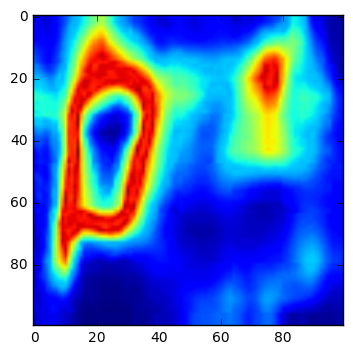

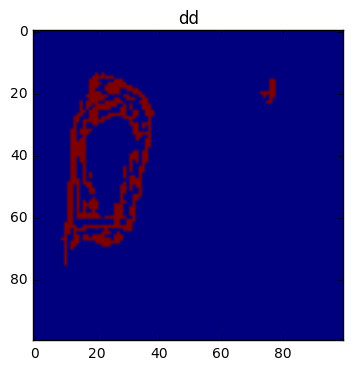

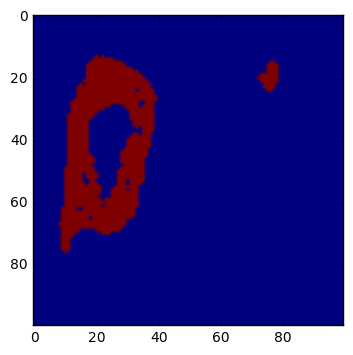

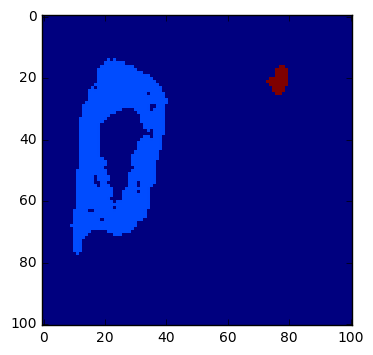

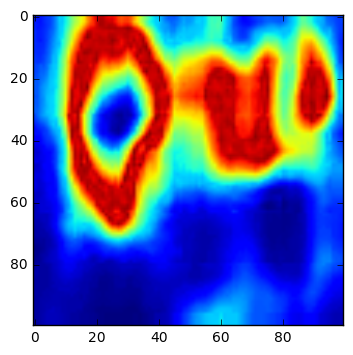

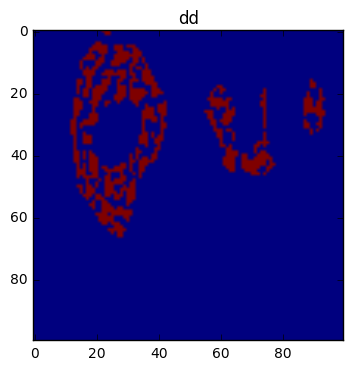

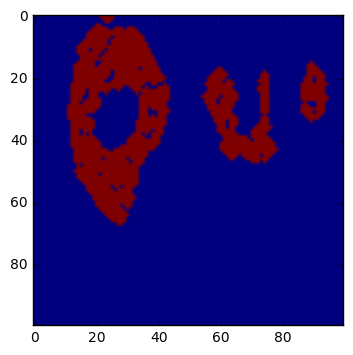

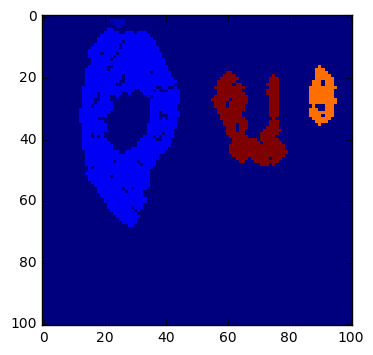

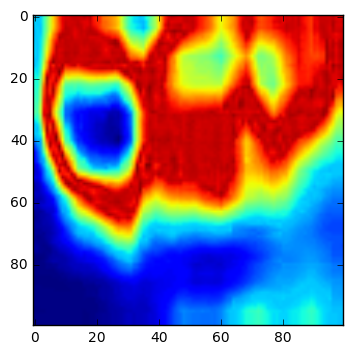

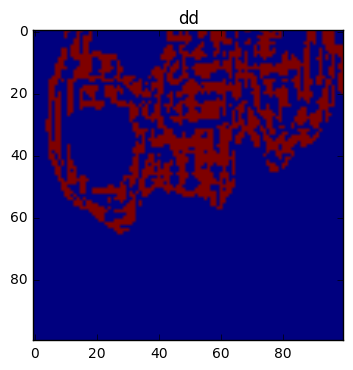

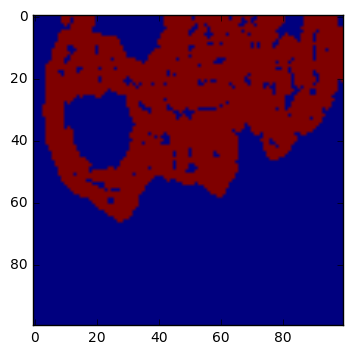

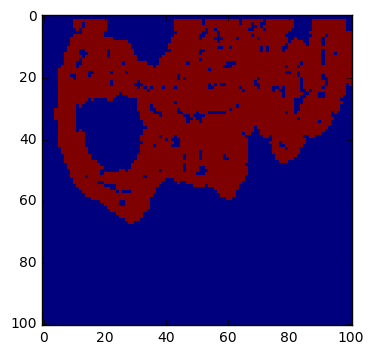

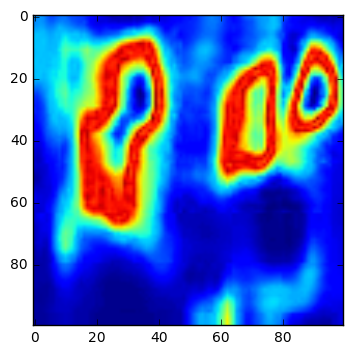

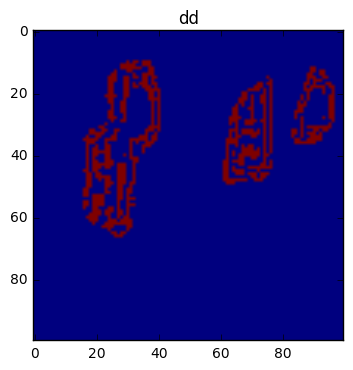

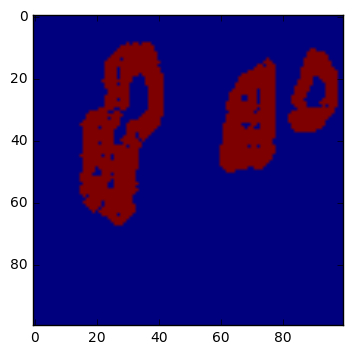

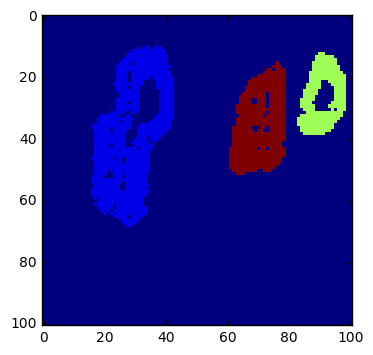

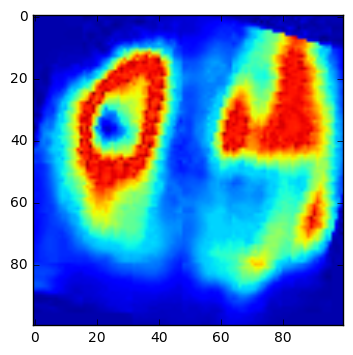

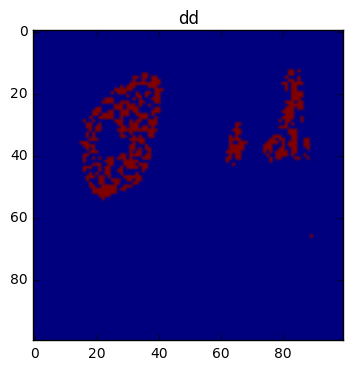

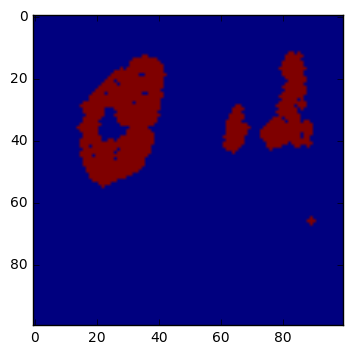

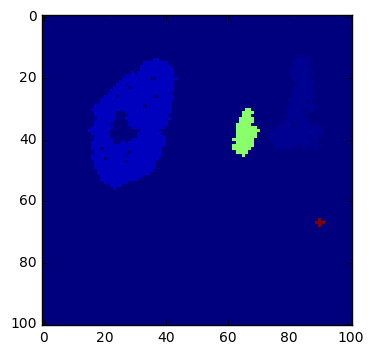

[[   8.           13.           41.           78.        ]
 [   8.           13.           39.56415094   75.09245283]
 [  72.           15.           80.           26.        ]
 [  73.48837209   15.1627907    80.           26.        ]
 [  21.            0.           27.            4.        ]
 [  21.54545455    0.           27.            3.45454545]
 [  11.            3.           45.           69.        ]
 [  11.            3.           42.74683544   62.87679325]
 [  86.           15.           96.           36.        ]
 [  86.           15.71186441   95.50847458   36.        ]
 [  54.           17.           80.           49.        ]
 [  54.           19.33149171   79.71270718   49.        ]
 [   3.            0.          101.           68.        ]
 [   3.            0.           99.53590285   55.28035903]
 [  15.            9.           43.           69.        ]
 [  15.            9.           41.9954955    68.37162162]
 [  82.           11.           99.           39.       

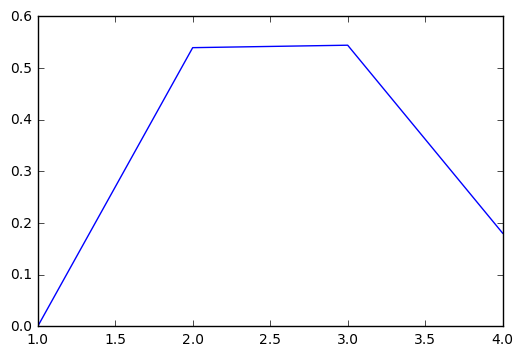

[3]


D:\Software\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:81: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  centers = np.empty((n_clusters, n_features), dtype=X.dtype)
D:\Software\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:106: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  for c in range(1, n_clusters):
D:\Software\Anaconda3\lib\site-packages\ipykernel\__main__.py:188: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[array([ 72.39593094,  23.153622  ,  85.90519291,  45.25      ]), array([ 10.27232877,   7.6       ,  54.18423847,  65.92815007]), array([ 21.27272727,   0.        ,  27.        ,   3.72727273])]


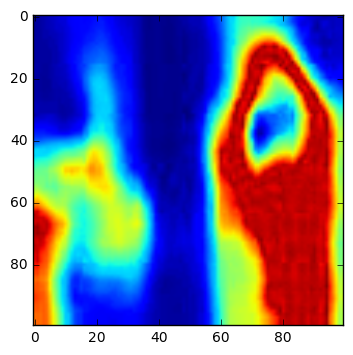

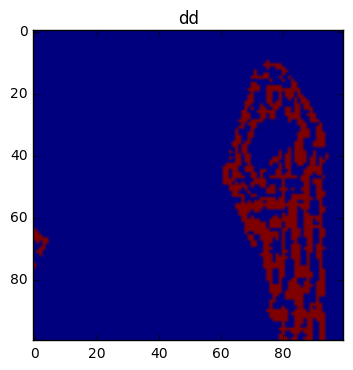

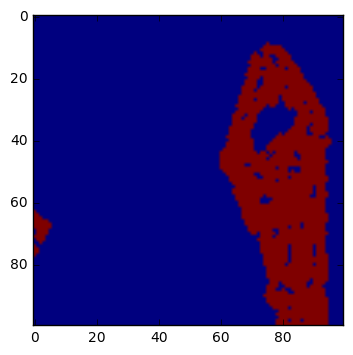

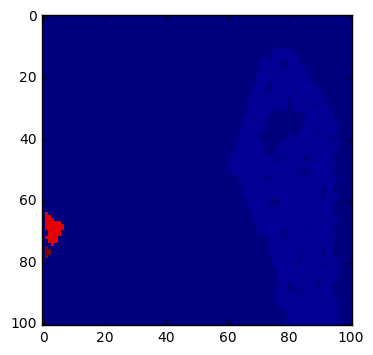

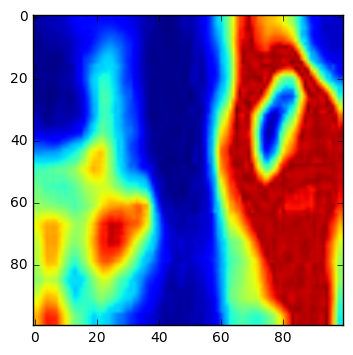

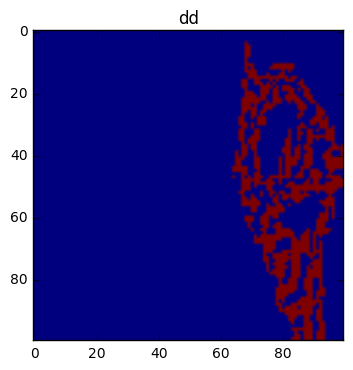

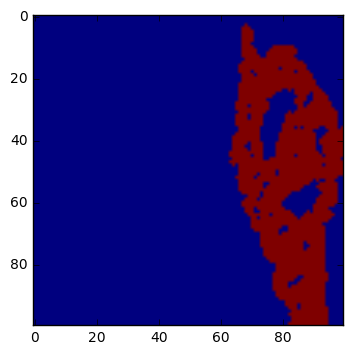

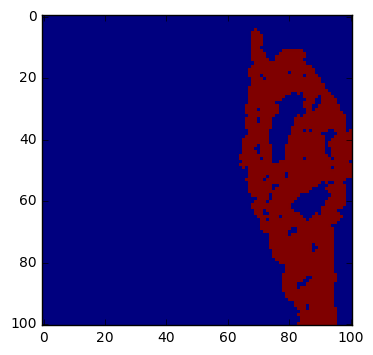

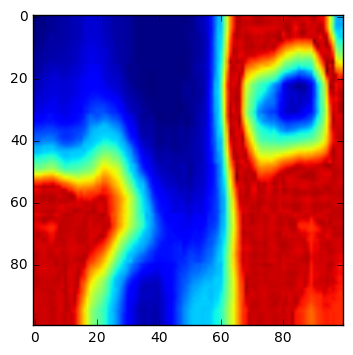

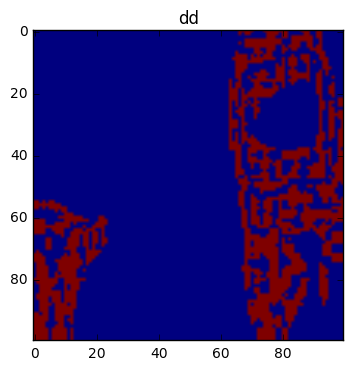

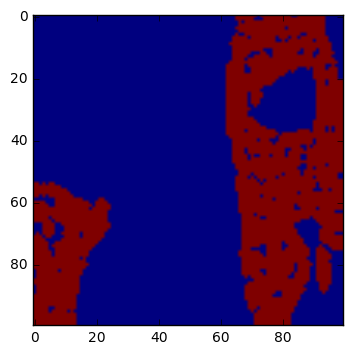

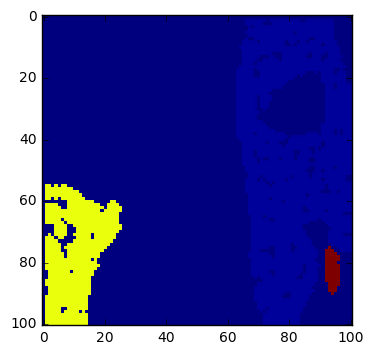

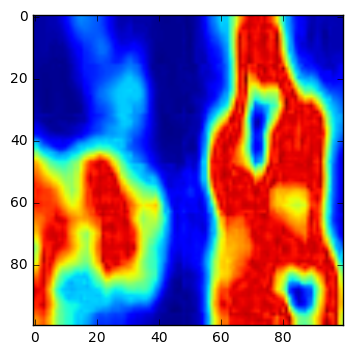

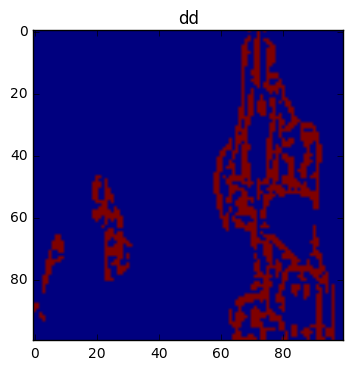

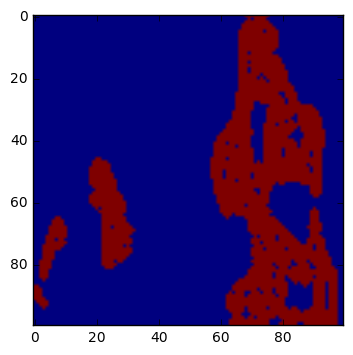

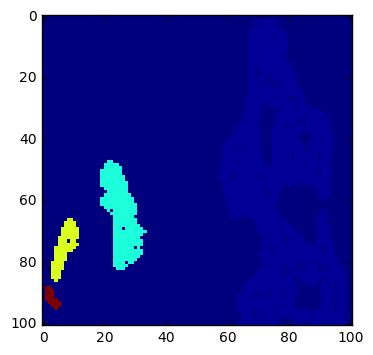

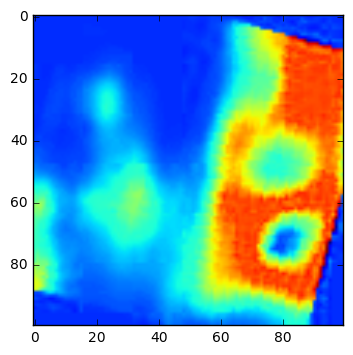

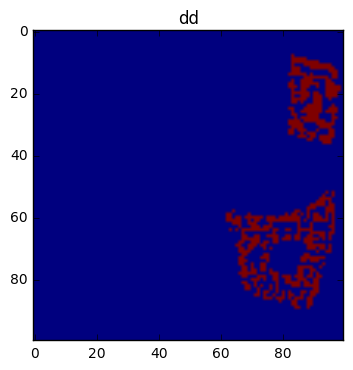

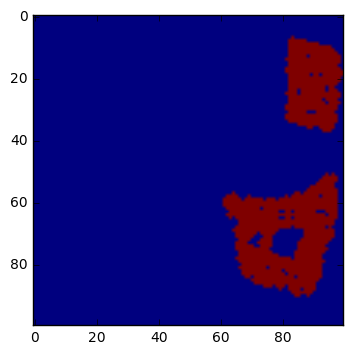

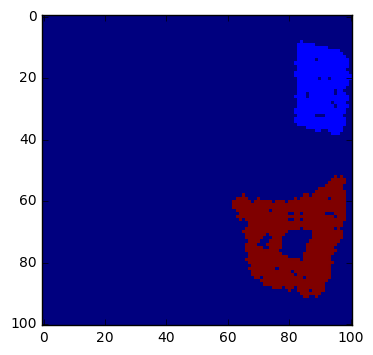

[[  60.            9.           97.          101.        ]
 [  65.33385013   11.07028424   97.          101.        ]
 [   0.           63.            7.           75.        ]
 [   0.           63.15384615    6.           75.        ]
 [   0.           74.            3.           79.        ]
 [   0.           74.            2.66666667   79.        ]
 [  63.            3.          101.          101.        ]
 [  64.17170682    3.          101.          100.93746797]
 [  62.            0.          101.          101.        ]
 [  62.            0.          100.32669323   94.57768924]
 [   0.           54.           26.          101.        ]
 [   0.           54.           20.53405995   99.53133515]
 [  91.           74.           97.           91.        ]
 [  91.           74.           96.80952381   90.76190476]
 [  57.            0.           99.          101.        ]
 [  57.           11.16566404   98.08468302  101.        ]
 [  18.           46.           34.           83.       

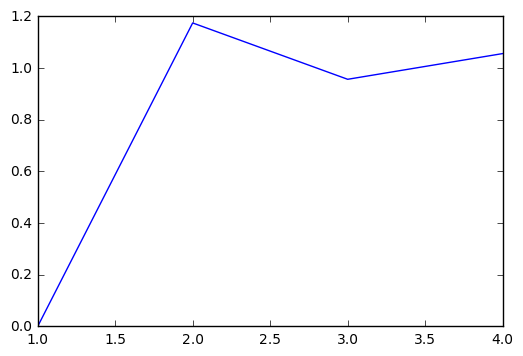

[2]
[array([  3.33333333,  64.91047152,  13.89224899,  86.53340836]), array([ 68.56631141,  21.55769768,  99.08091885,  88.94836157])]


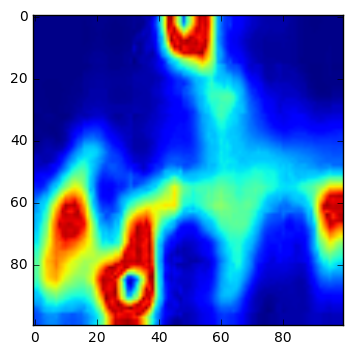

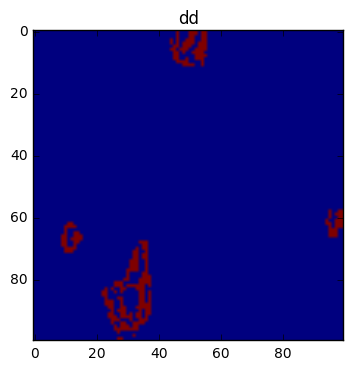

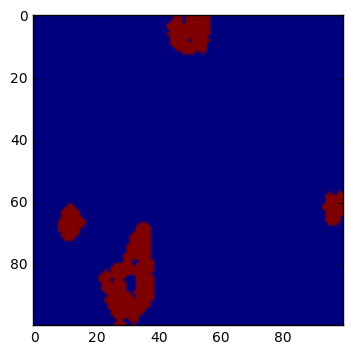

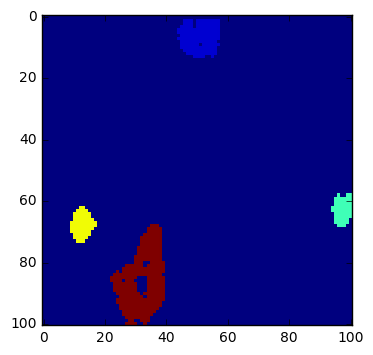

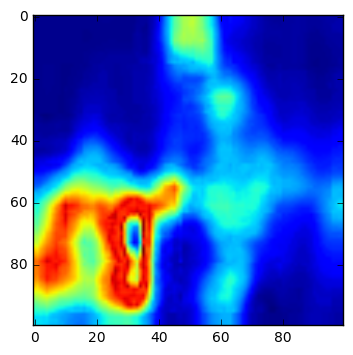

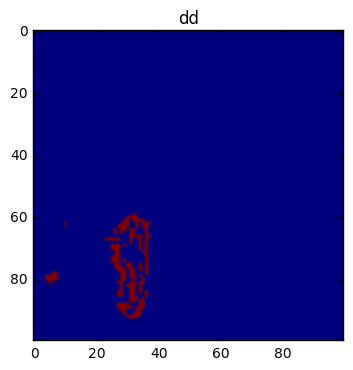

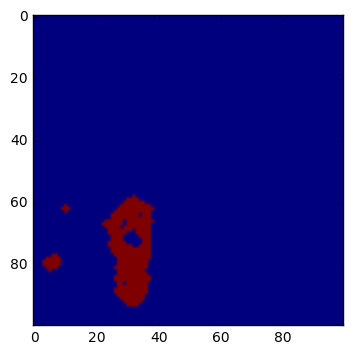

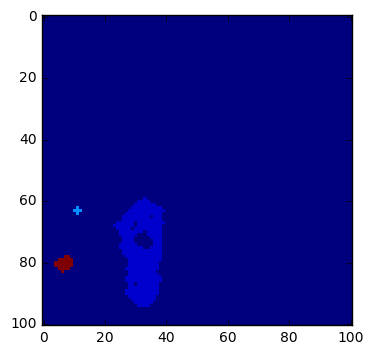

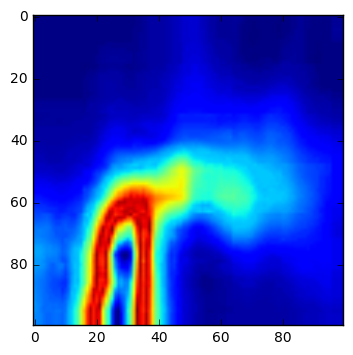

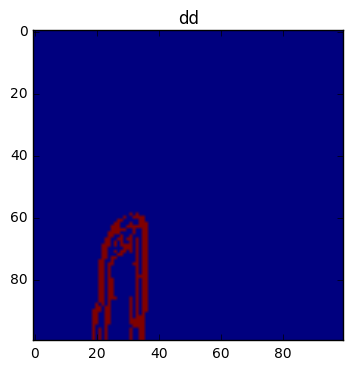

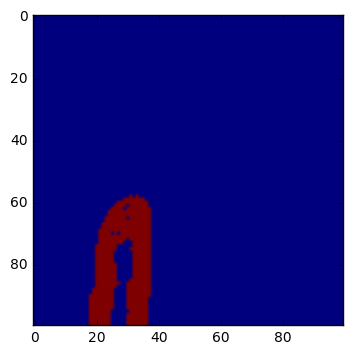

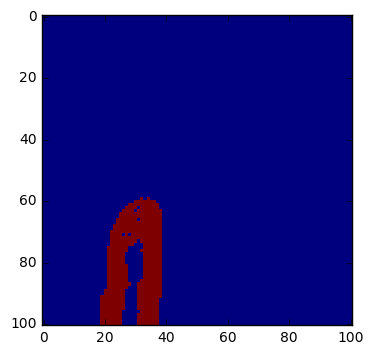

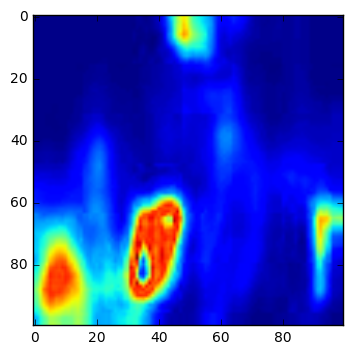

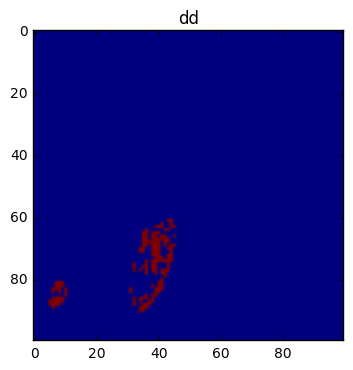

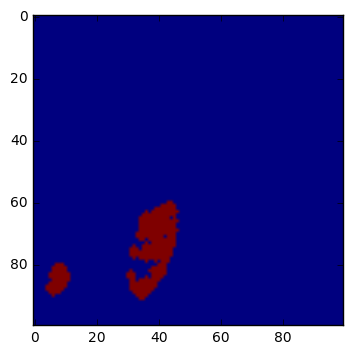

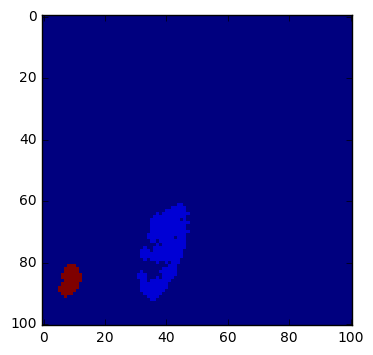

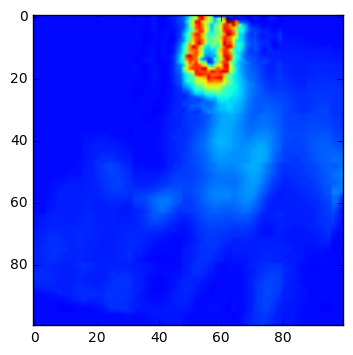

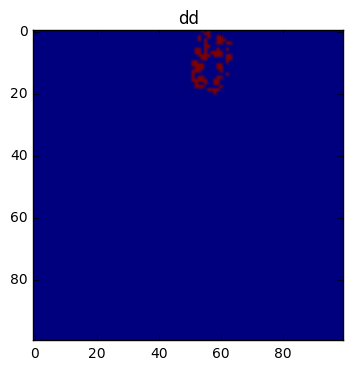

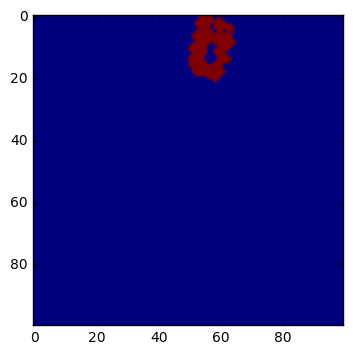

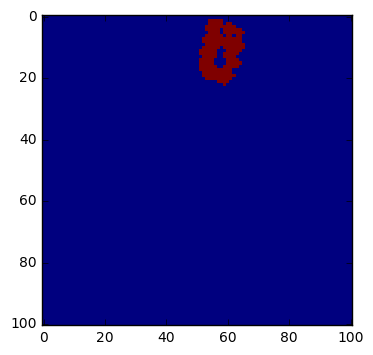

[[  43.            0.           58.           14.        ]
 [  43.89403974    0.           58.           13.25827815]
 [  93.           57.          101.           69.        ]
 [  93.63333333   57.          101.           68.73333333]
 [   8.           61.           18.           74.        ]
 [   8.           61.38888889   17.13888889   74.        ]
 [  21.           67.           40.          101.        ]
 [  24.25655977   70.31195335   40.          101.        ]
 [  22.           58.           40.           95.        ]
 [  24.16939891   58.           40.           94.50819672]
 [   9.           61.           13.           65.        ]
 [   9.           61.           13.           65.        ]
 [   3.           77.           10.           84.        ]
 [   3.33333333   77.           10.           83.66666667]
 [  18.           58.           39.          101.        ]
 [  20.16695958   59.86818981   39.          101.        ]
 [  30.           60.           48.           93.       

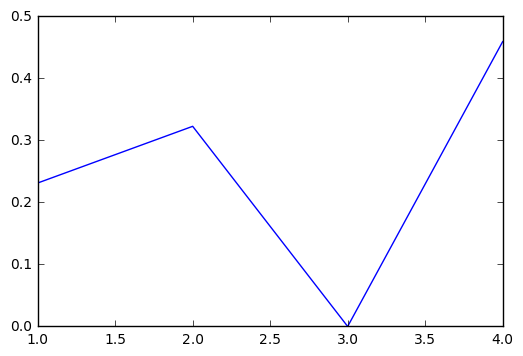

[4]
[array([  6.06140351,  69.79861111,  13.39236111,  78.65570175]), array([ 46.72350993,   0.        ,  61.79812207,  18.04344278]), array([  93.31666667,   57.        ,  101.        ,   68.86666667]), array([ 23.82585089,  61.39751789,  41.75      ,  97.14772598])]


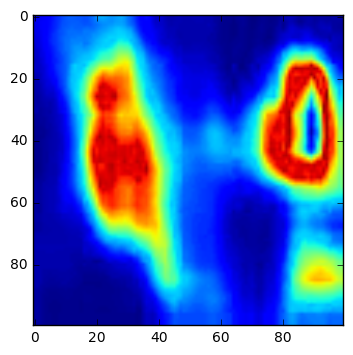

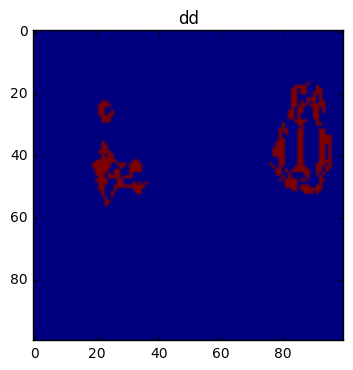

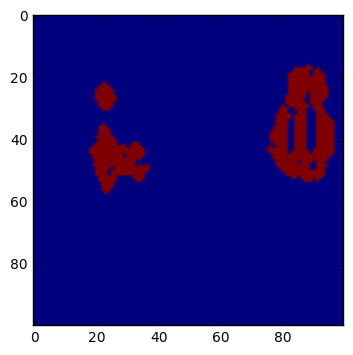

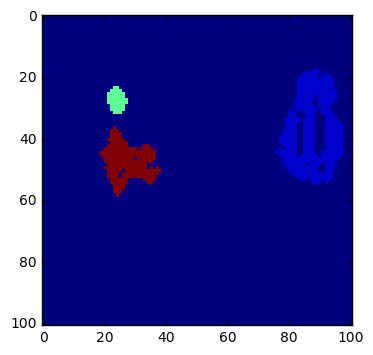

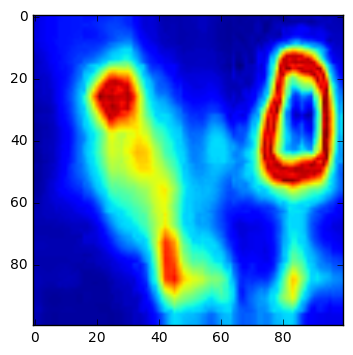

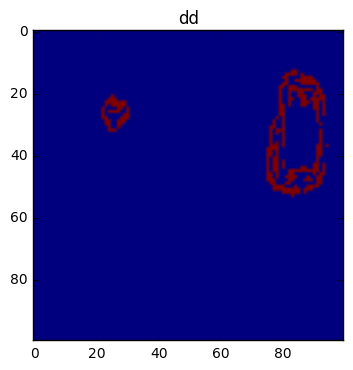

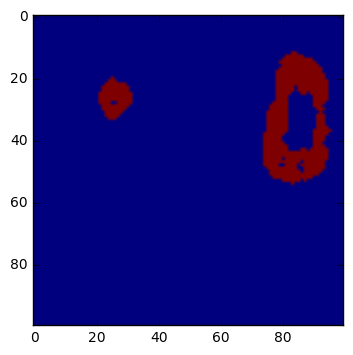

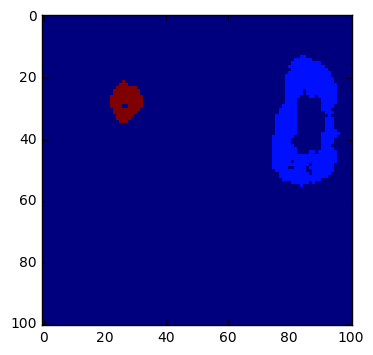

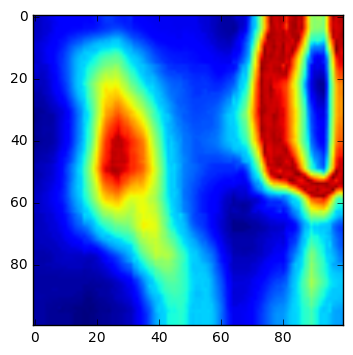

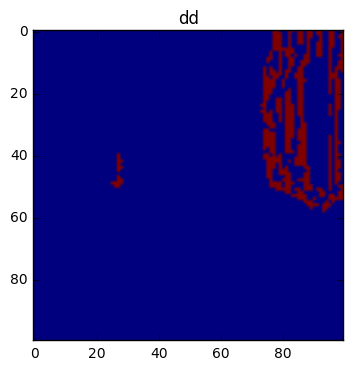

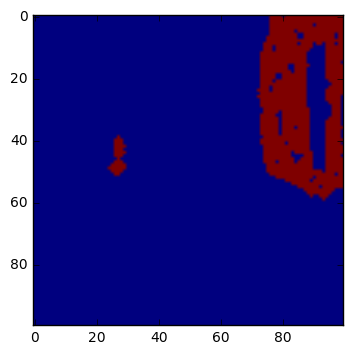

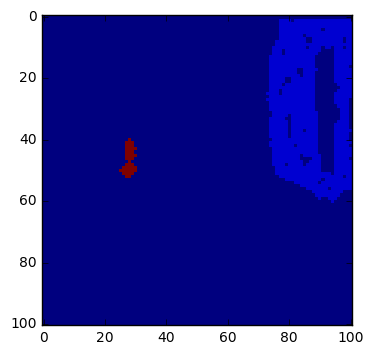

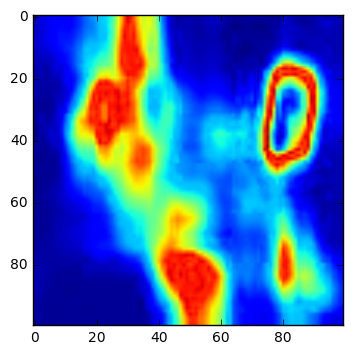

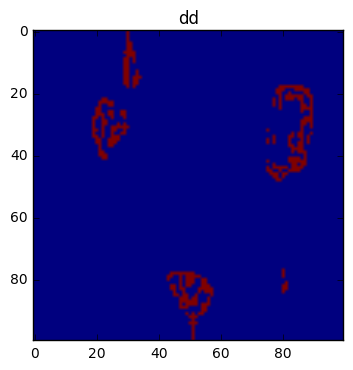

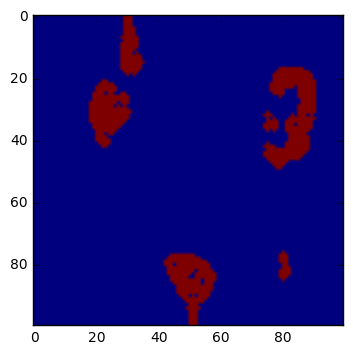

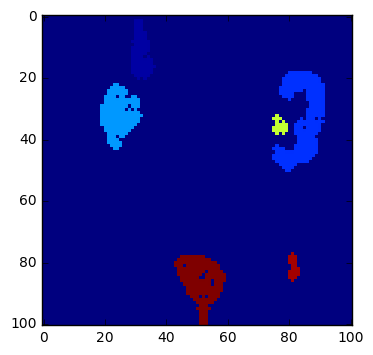

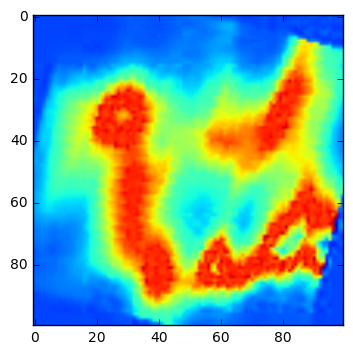

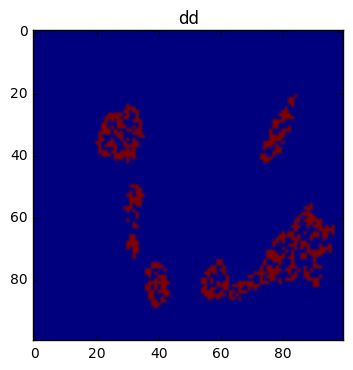

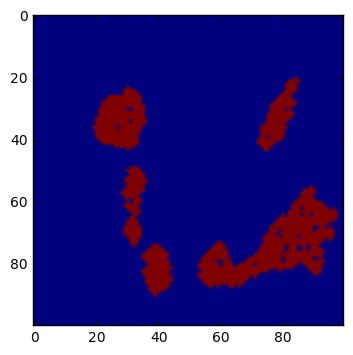

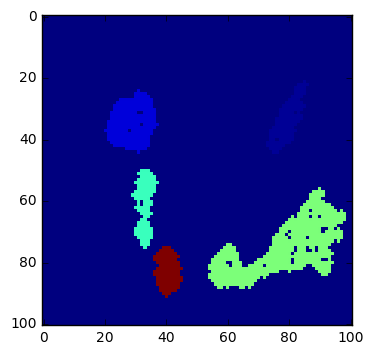

[[  75.           16.           98.           55.        ]
 [  77.08829569   18.66735113   98.           55.        ]
 [  20.           22.           28.           32.        ]
 [  20.           22.26666667   27.6          32.        ]
 [  18.           35.           39.           59.        ]
 [  18.           35.55605381   36.52017937   59.        ]
 [  74.           12.           97.           56.        ]
 [  74.           13.69087523   96.23836127   56.        ]
 [  21.           20.           33.           35.        ]
 [  21.           20.25490196   32.64705882   35.        ]
 [  72.            0.          101.           61.        ]
 [  72.58419244    0.          101.           56.7233677 ]
 [  24.           39.           31.           53.        ]
 [  24.9047619    40.0952381    31.           53.        ]
 [  28.            0.           37.           21.        ]
 [  28.            2.14         35.36         21.        ]
 [  74.           17.           92.           51.       

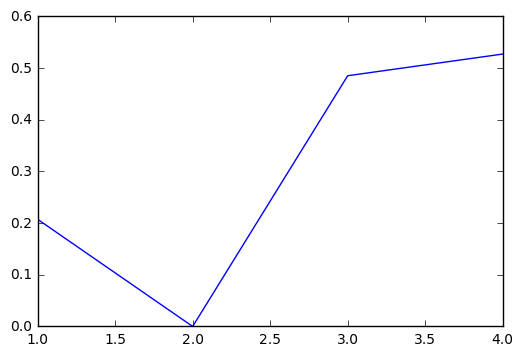

[4]
[array([ 21.24172148,  23.24017481,  33.65732193,  41.19969278]), array([ 67.41638514,  67.06306306,  91.39814815,  88.        ]), array([ 73.95390824,  16.60792459,  92.42022118,  50.63912464]), array([ 35.10047847,  66.66666667,  47.94253726,  88.25984728])]


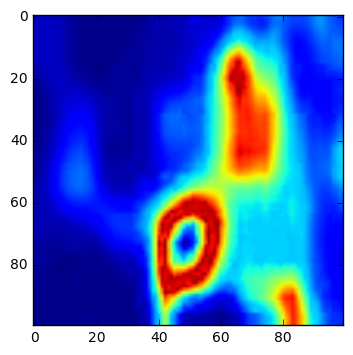

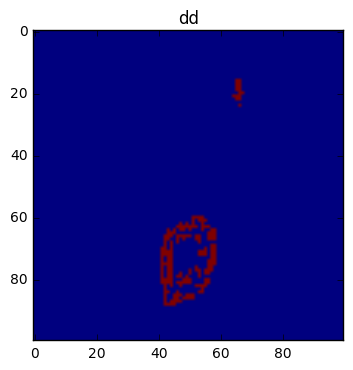

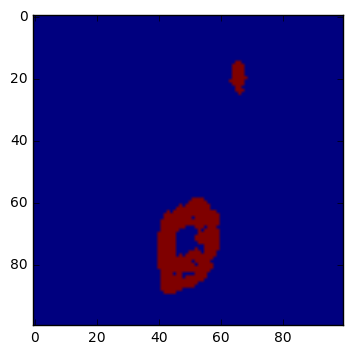

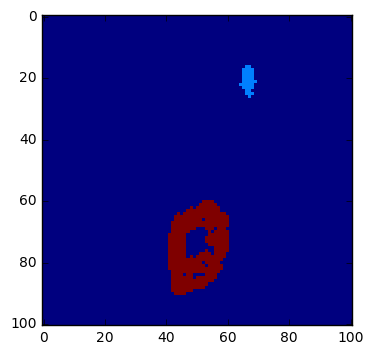

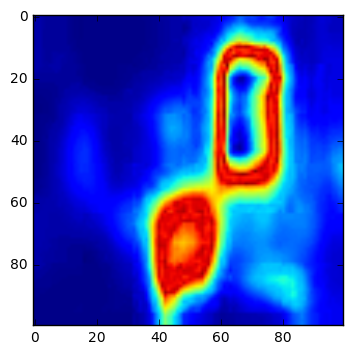

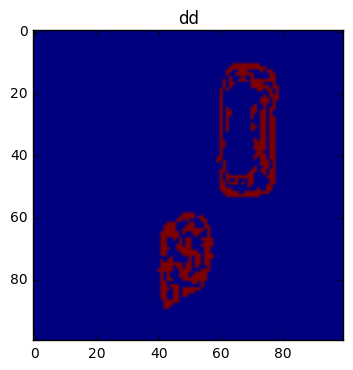

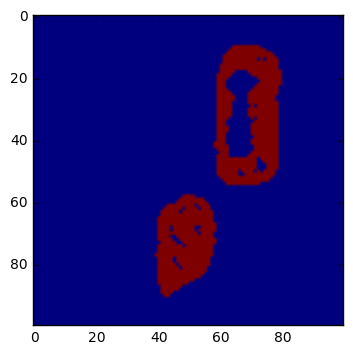

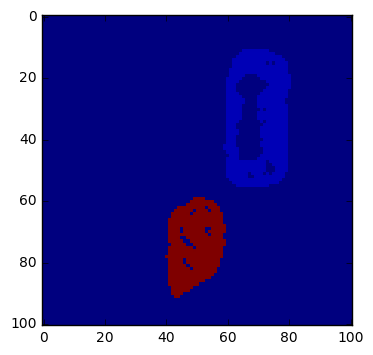

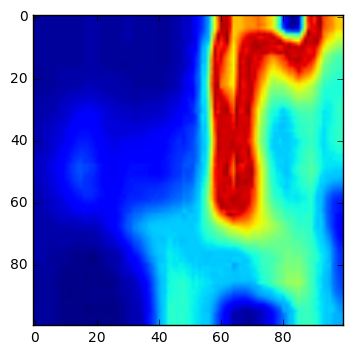

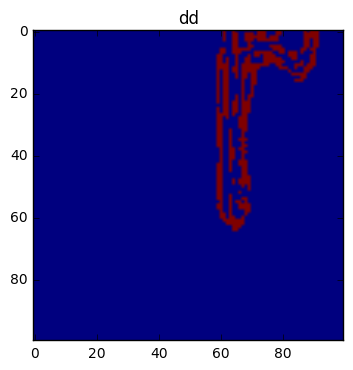

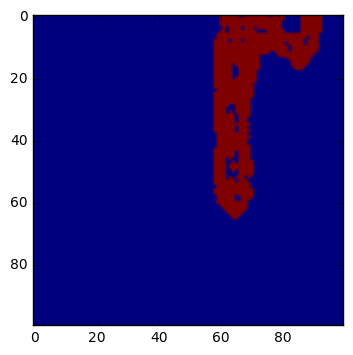

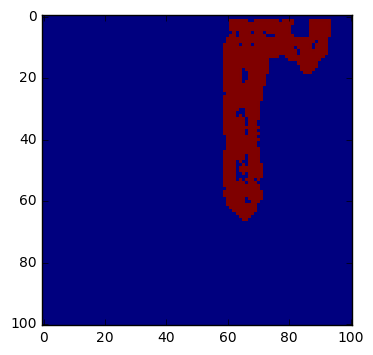

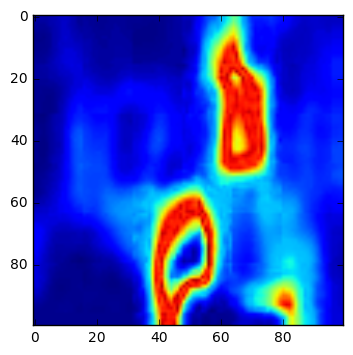

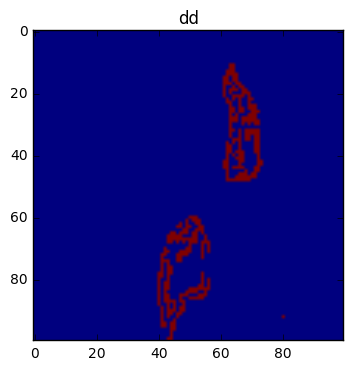

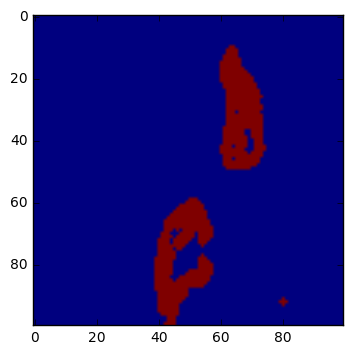

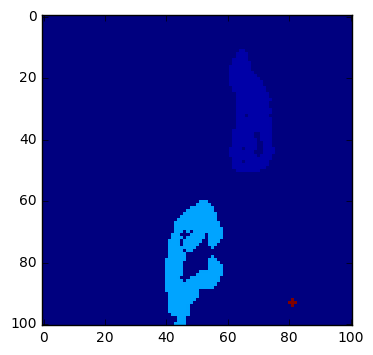

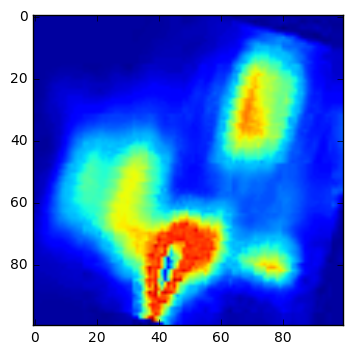

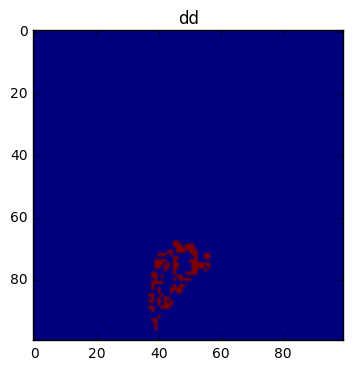

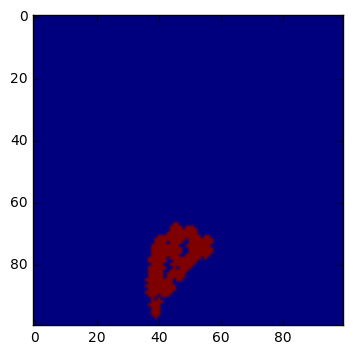

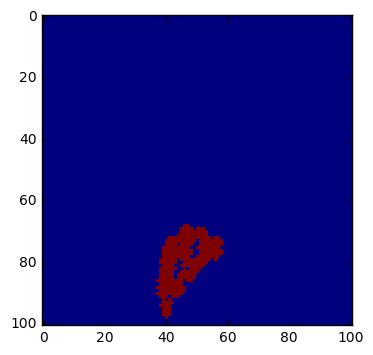

[[  63.           15.           70.           27.        ]
 [  63.10526316   15.           70.           26.26315789]
 [  40.           59.           61.           91.        ]
 [  40.           59.           60.21515892   90.86797066]
 [  58.           10.           81.           56.        ]
 [  59.42633229   10.26959248   81.           56.        ]
 [  39.           58.           60.           92.        ]
 [  39.           58.           59.38596491   90.23245614]
 [  58.            0.           94.           67.        ]
 [  58.            0.           81.46868687   50.66464646]
 [  60.           10.           76.           51.        ]
 [  60.           14.27407407   74.51358025   51.        ]
 [  39.           59.           59.          101.        ]
 [  39.           59.           57.38028169   98.55868545]
 [  79.           91.           83.           95.        ]
 [  79.           91.           83.           95.        ]
 [  36.           67.           59.           99.       

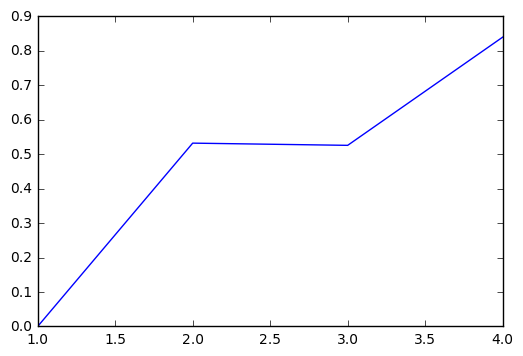

[4]
[array([ 58.90438871,   7.42394443,  81.33037785,  55.27744108]), array([ 38.5       ,  60.75      ,  58.93761076,  94.46225916]), array([ 63.05263158,  15.        ,  70.        ,  26.63157895]), array([ 79.,  91.,  83.,  95.])]


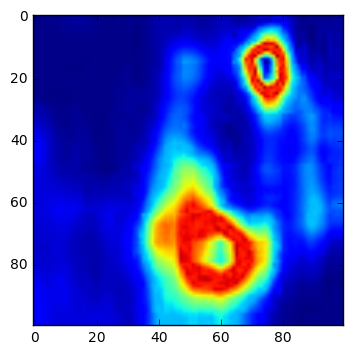

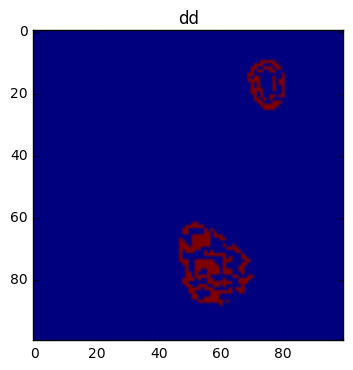

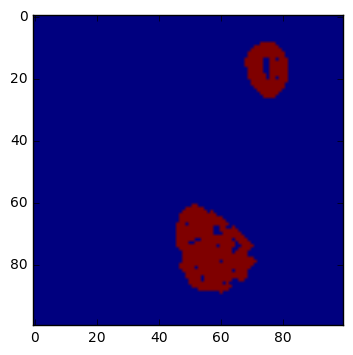

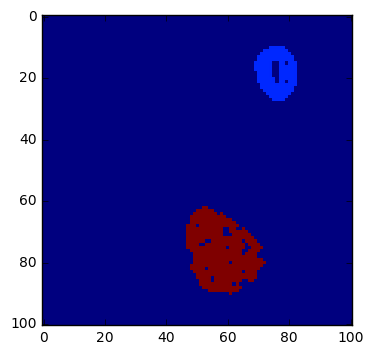

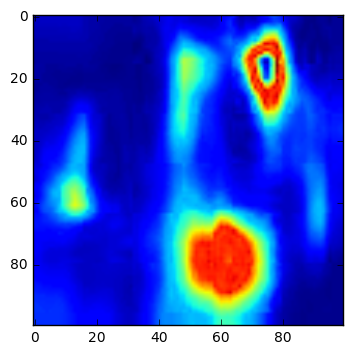

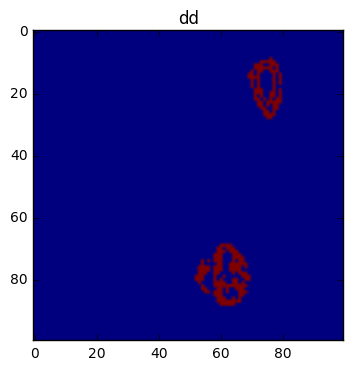

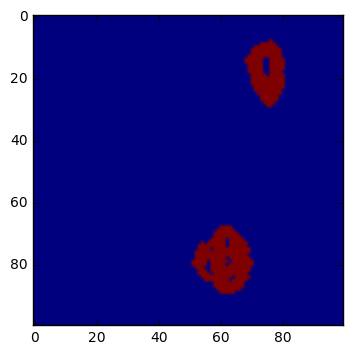

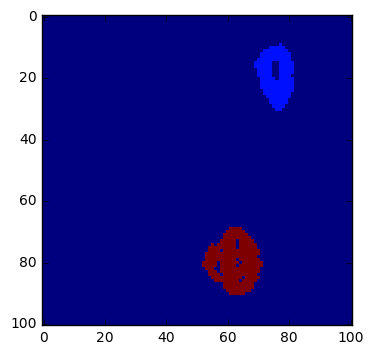

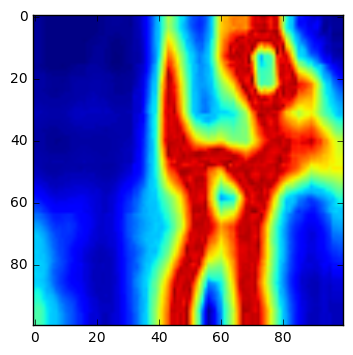

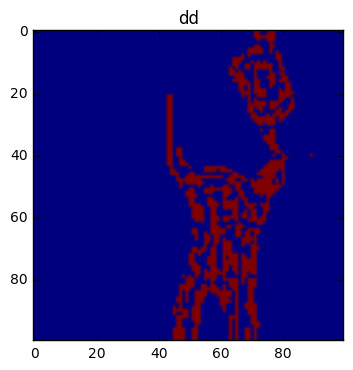

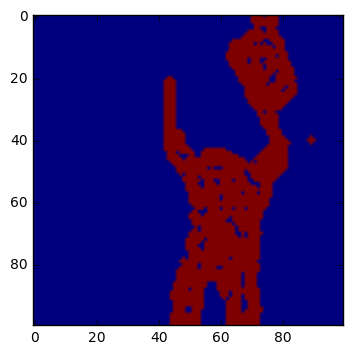

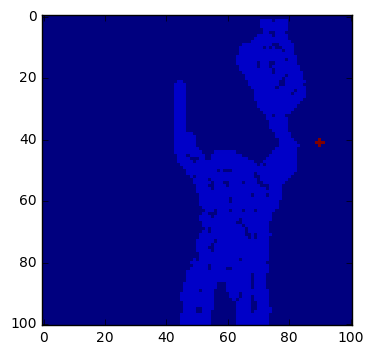

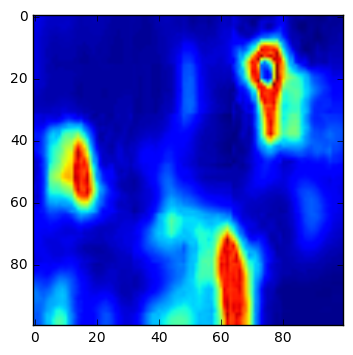

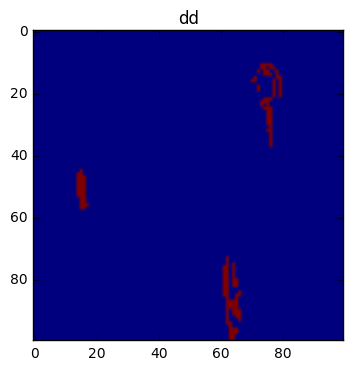

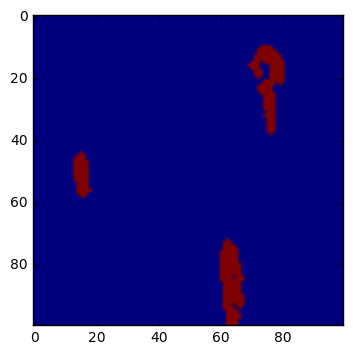

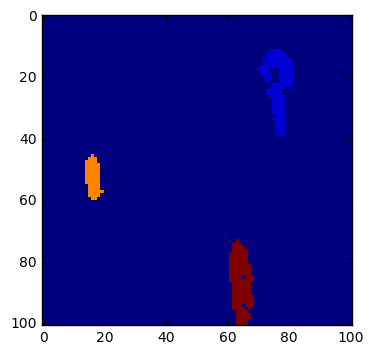

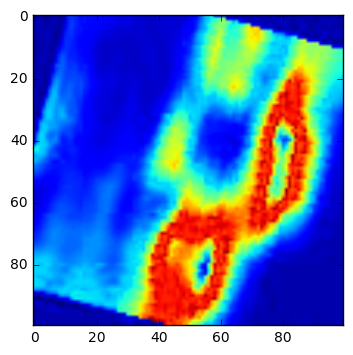

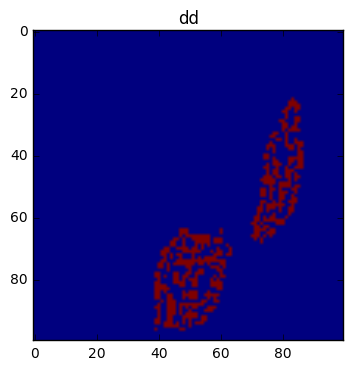

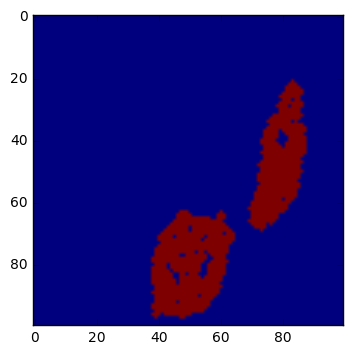

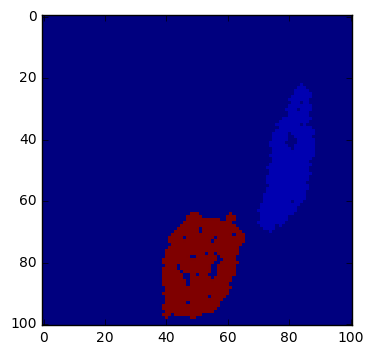

[[  68.            9.           83.           28.        ]
 [  68.74157303    9.           83.           27.42696629]
 [  46.           61.           73.           91.        ]
 [  46.           62.11392405   69.64556962   91.        ]
 [  68.            8.           82.           31.        ]
 [  69.45652174    8.           82.           30.23913043]
 [  51.           68.           72.           91.        ]
 [  52.28158845   68.58844765   72.           91.        ]
 [  42.            0.           86.          101.        ]
 [  42.66199299    9.30245368   86.          101.        ]
 [  88.           39.           92.           43.        ]
 [  88.           39.           92.           43.        ]
 [  69.           10.           82.           40.        ]
 [  70.77419355   10.           82.           34.09032258]
 [  13.           44.           20.           60.        ]
 [  13.           44.35483871   19.32258065   60.        ]
 [  60.           72.           69.          101.       

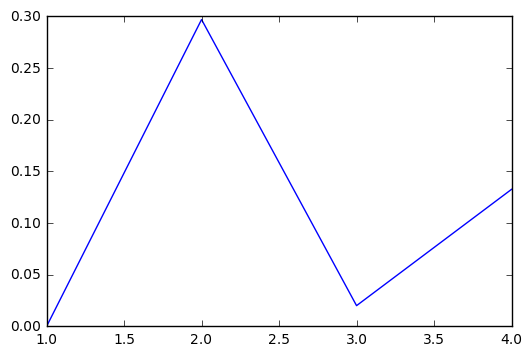

[2]
[array([ 41.82863179,  52.31689184,  63.76948493,  90.48784195]), array([ 72.98339484,  17.7284585 ,  85.6       ,  41.87564193])]


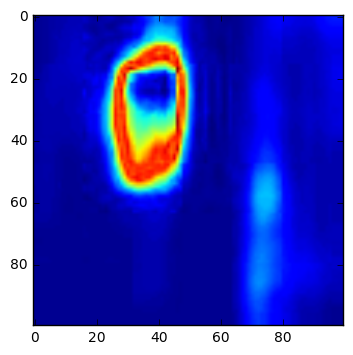

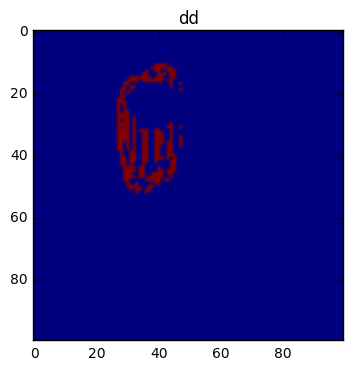

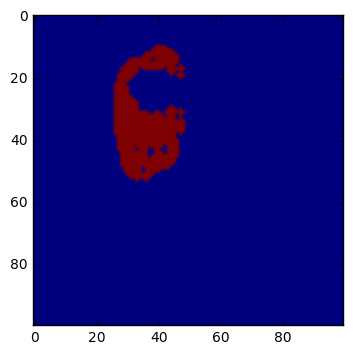

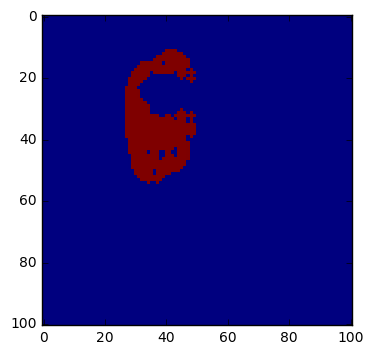

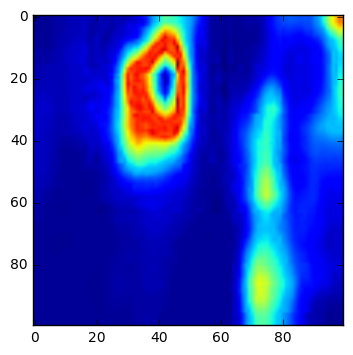

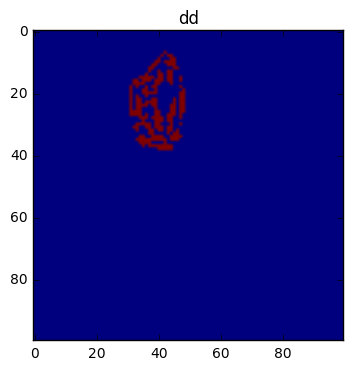

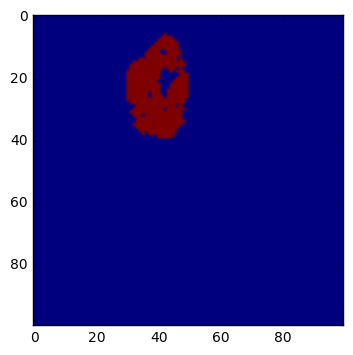

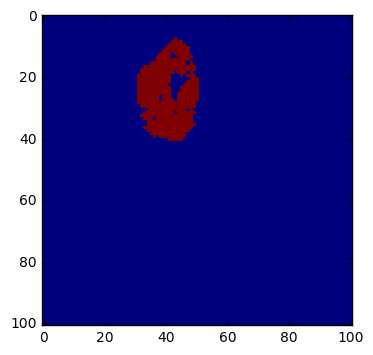

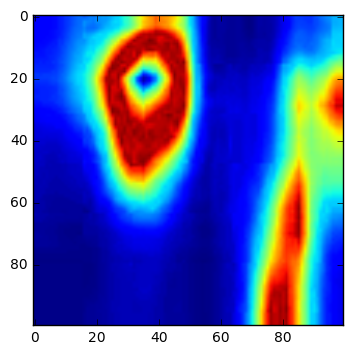

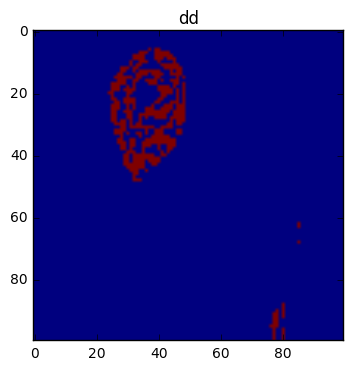

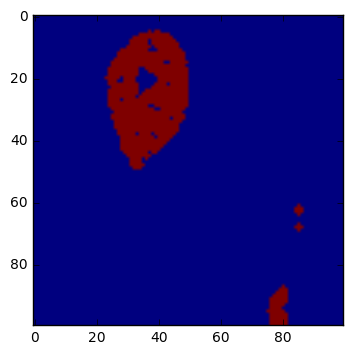

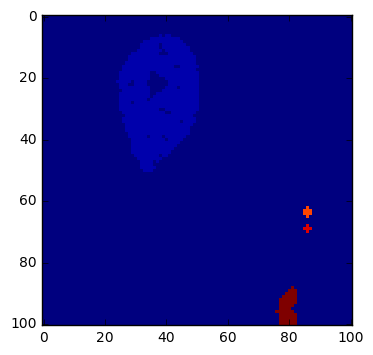

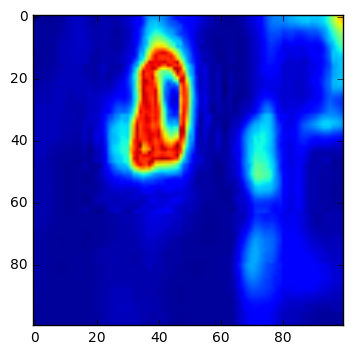

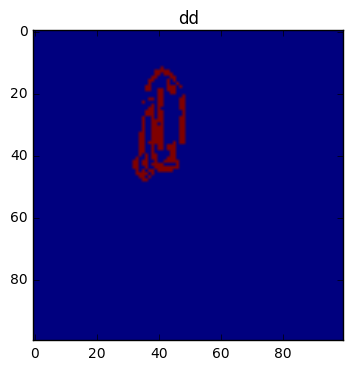

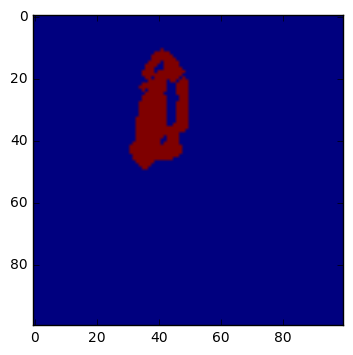

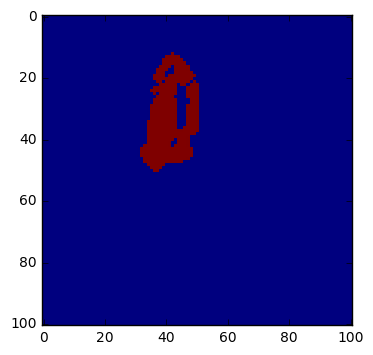

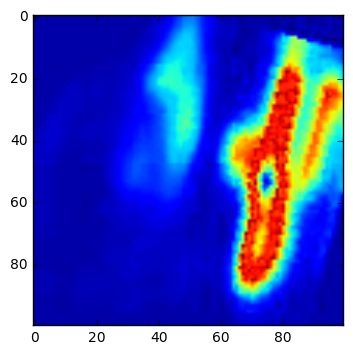

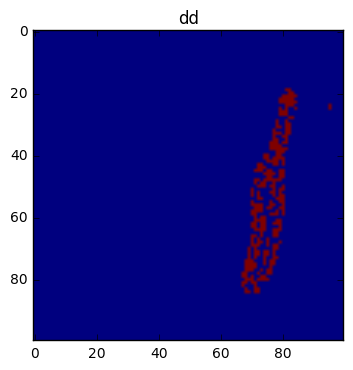

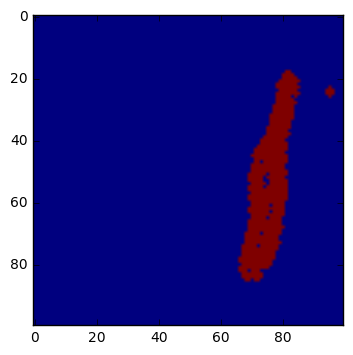

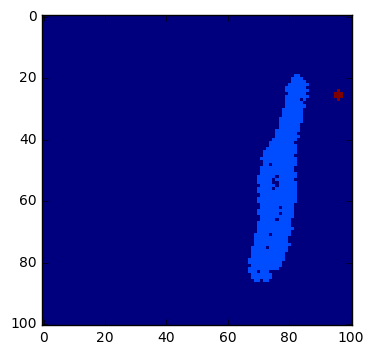

[[  26.           10.           50.           55.        ]
 [  26.           13.68135593   48.00338983   55.        ]
 [  30.            6.           51.           41.        ]
 [  30.32599119    8.83700441   51.           41.        ]
 [  23.            5.           51.           51.        ]
 [  23.9761606     5.           51.           47.98368883]
 [  84.           61.           88.           66.        ]
 [  84.           61.           88.           66.        ]
 [  84.           67.           88.           71.        ]
 [  84.           67.           88.           71.        ]
 [  75.           87.           83.          101.        ]
 [  76.           88.6875       83.          101.        ]
 [  31.           11.           51.           51.        ]
 [  31.74387528   13.56570156   51.           51.        ]
 [  66.           18.           87.           87.        ]
 [  66.           23.5588697    86.94819466   87.        ]
 [  94.           23.           98.           28.       

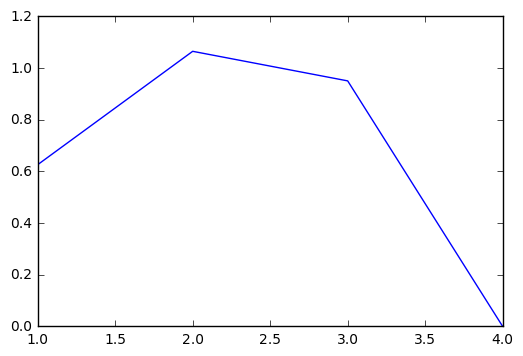

[2]
[array([ 27.75575338,   9.13550774,  50.50042373,  49.1229611 ]), array([ 80.7       ,  51.92463697,  88.79481947,  70.6       ])]


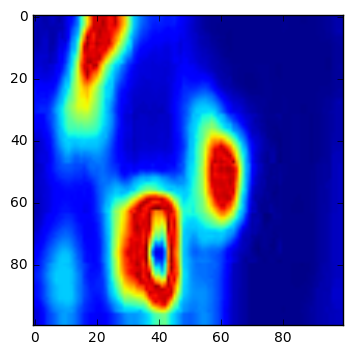

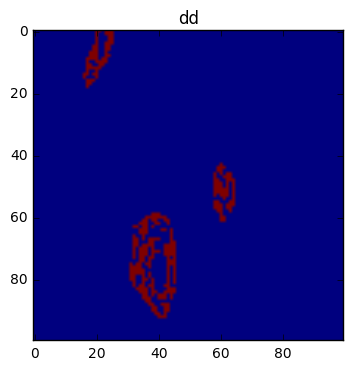

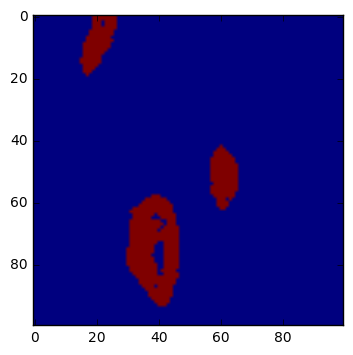

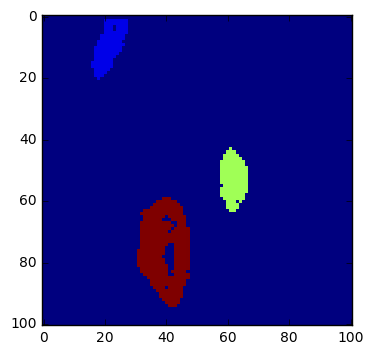

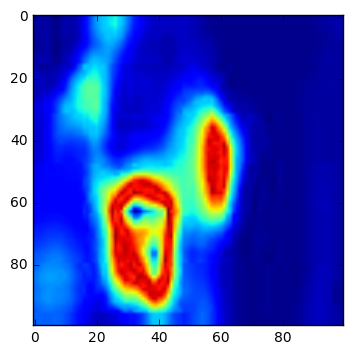

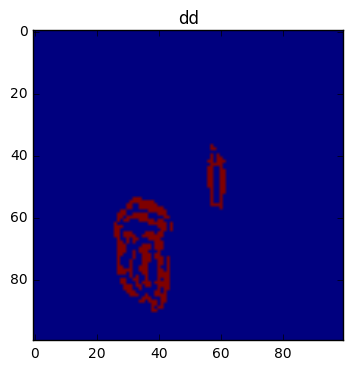

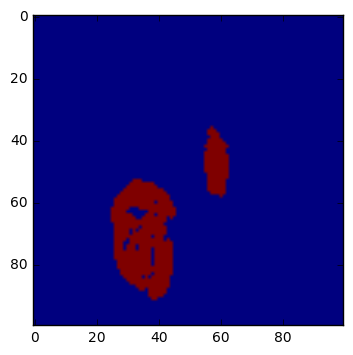

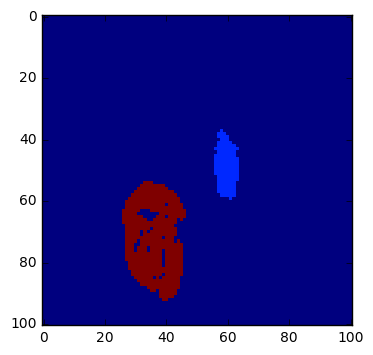

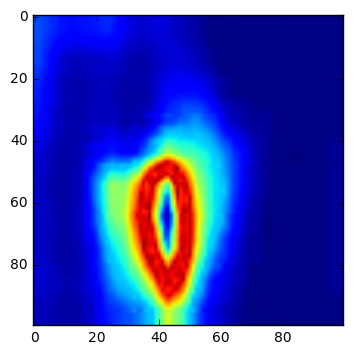

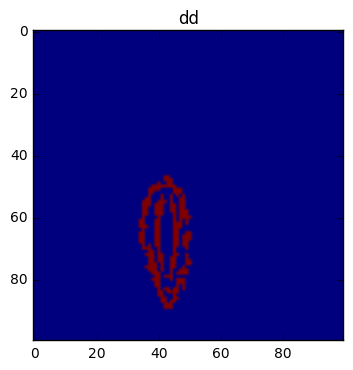

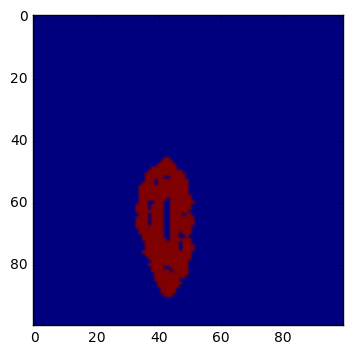

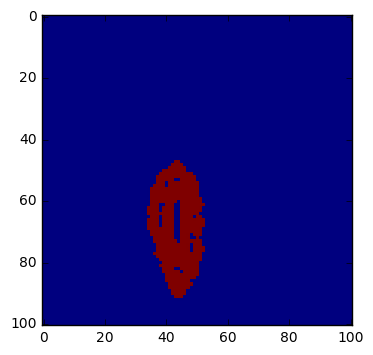

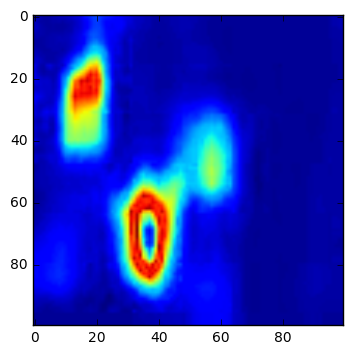

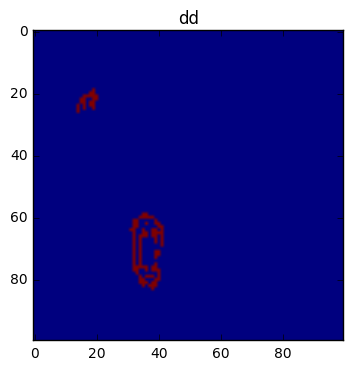

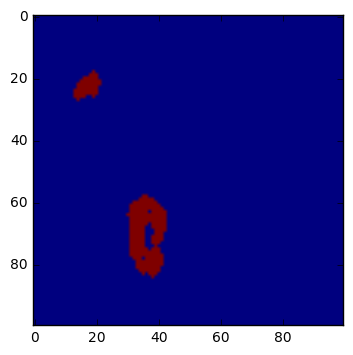

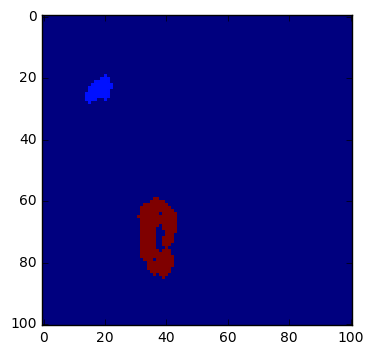

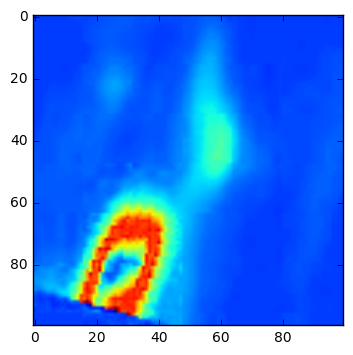

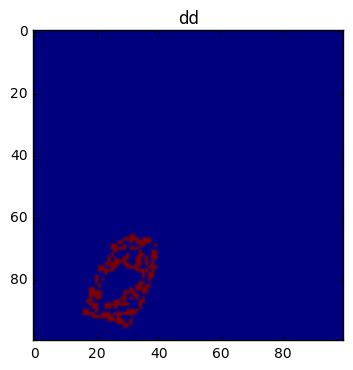

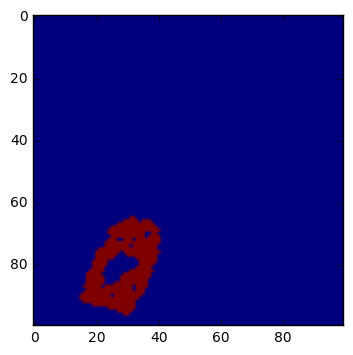

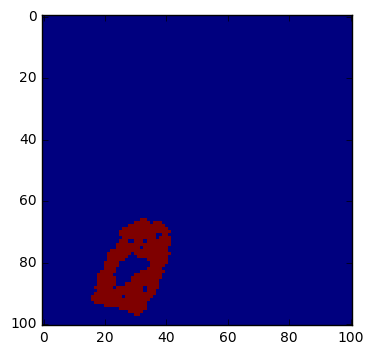

[[ 15.           0.          28.          21.        ]
 [ 15.           0.          27.77372263  18.58394161]
 [ 57.          42.          67.          64.        ]
 [ 57.          42.          66.62857143  63.84285714]
 [ 30.          58.          48.          95.        ]
 [ 30.97169811  58.          48.          93.38679245]
 [ 55.          36.          64.          60.        ]
 [ 55.          37.05185185  63.9037037   60.        ]
 [ 25.          53.          47.          93.        ]
 [ 25.33273703  53.          47.          91.48658318]
 [ 33.          46.          53.          92.        ]
 [ 33.71428571  46.          53.          90.45787546]
 [ 13.          18.          23.          29.        ]
 [ 13.18867925  18.58490566  23.          29.        ]
 [ 30.          58.          44.          86.        ]
 [ 30.24242424  58.          44.          84.65800866]
 [ 15.          65.          42.          98.        ]
 [ 17.20357942  65.14541387  42.          98.        ]]
(13.0, 67

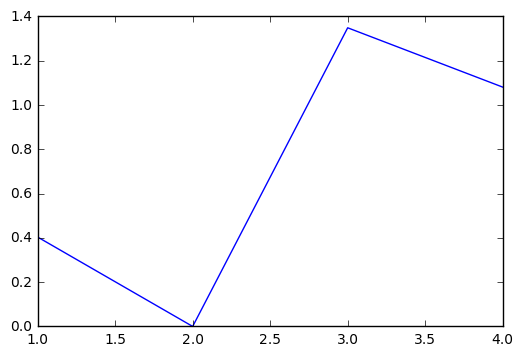

[3]
[array([ 14.04716981,   9.14622642,  25.44343066,  24.3959854 ]), array([ 56.        ,  39.26296296,  65.38306878,  61.96071429]), array([ 27.04647245,  56.01454139,  46.8       ,  92.19892598])]


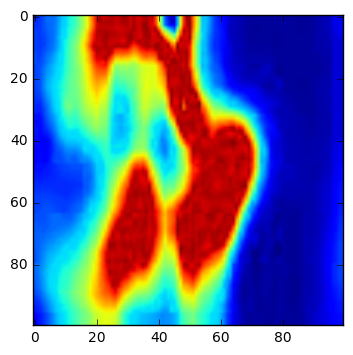

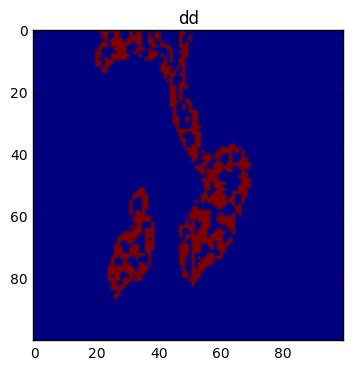

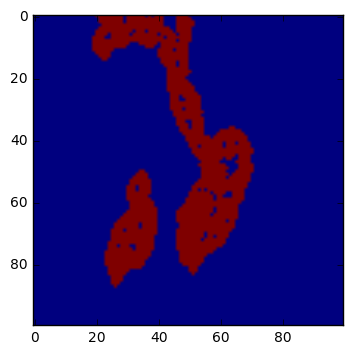

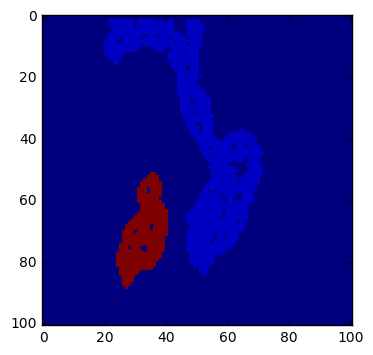

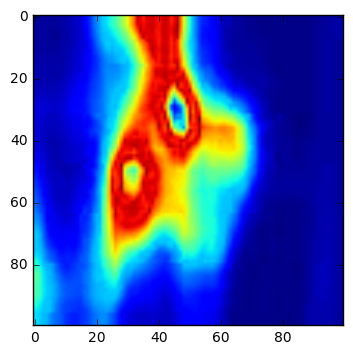

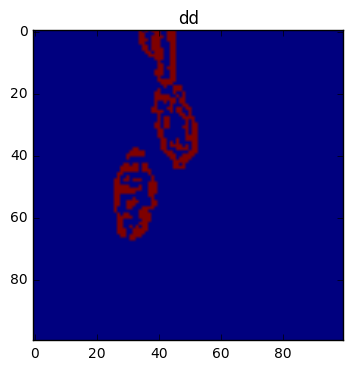

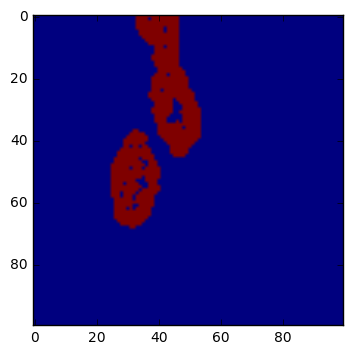

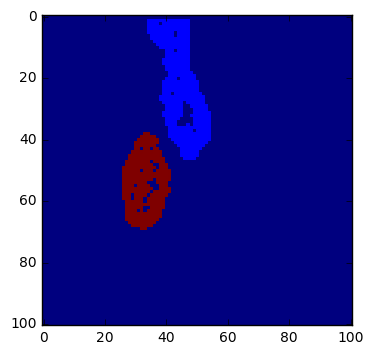

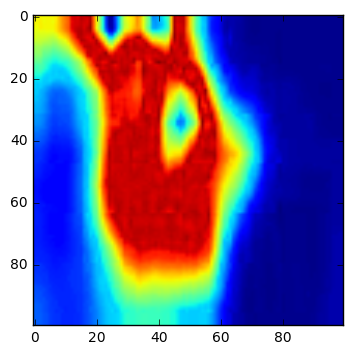

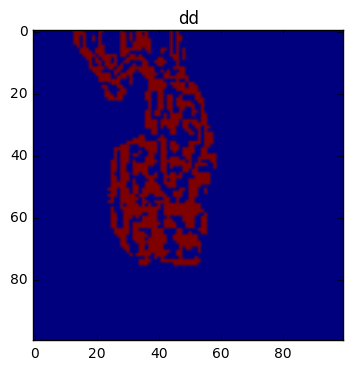

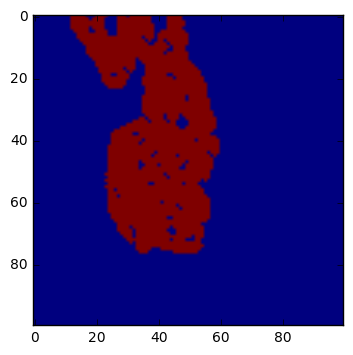

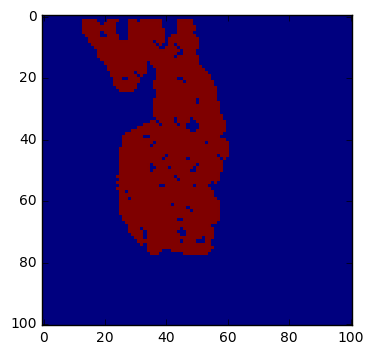

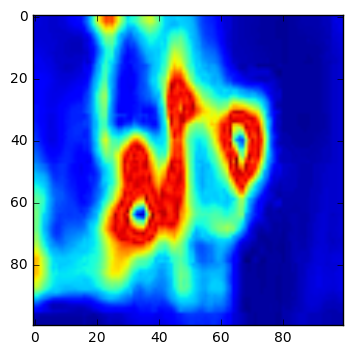

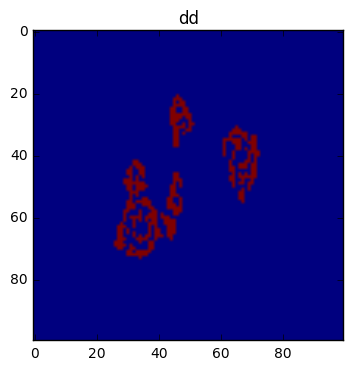

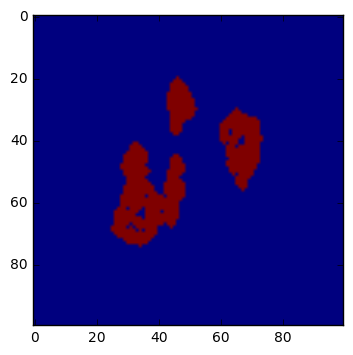

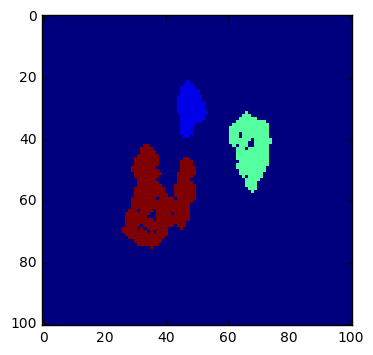

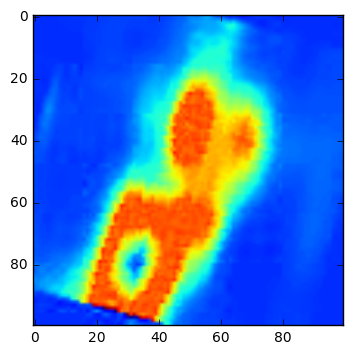

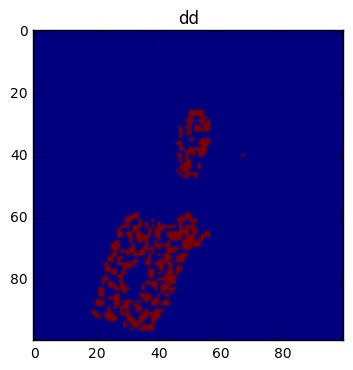

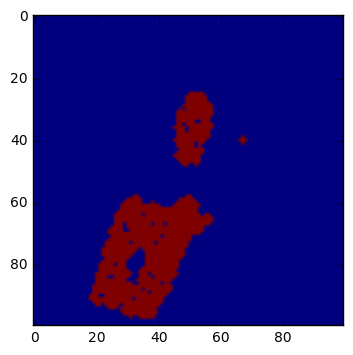

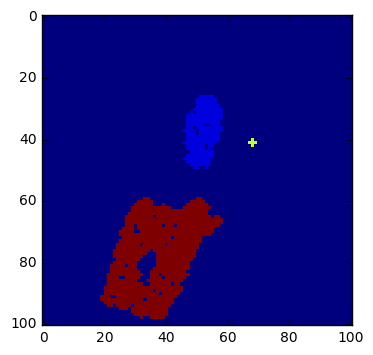

[[ 19.           0.          72.          85.        ]
 [ 29.03986981   0.          72.          78.48169243]
 [ 23.          50.          41.          89.        ]
 [ 24.27823691  51.65564738  41.          89.        ]
 [ 33.           0.          55.          47.        ]
 [ 34.28316832   0.          55.          45.72277228]
 [ 25.          37.          42.          70.        ]
 [ 25.          38.20408163  41.01166181  70.        ]
 [ 12.           0.          61.          78.        ]
 [ 18.87668057   0.          61.          77.405656  ]
 [ 43.          20.          54.          40.        ]
 [ 43.          20.          52.37931034  39.79310345]
 [ 60.          30.          75.          58.        ]
 [ 60.22608696  30.          75.          55.62608696]
 [ 25.          41.          50.          76.        ]
 [ 25.          43.2043956   49.4043956   76.        ]
 [ 45.          25.          59.          50.        ]
 [ 45.          25.          58.94444444  49.37962963]
 [ 66.    

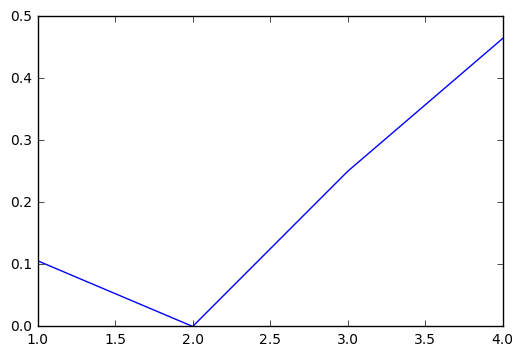

[4]
[array([ 19.7291376 ,   0.        ,  66.5       ,  79.72183711]), array([ 63.05652174,  34.5       ,  72.5       ,  49.90652174]), array([ 22.90977961,  47.13301558,  47.38477362,  83.26955782]), array([ 40.54719472,  15.        ,  55.7206258 ,  45.31591756])]


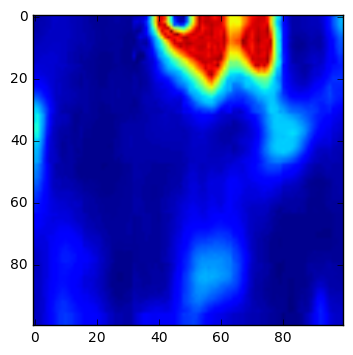

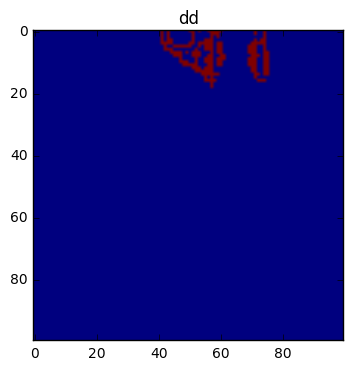

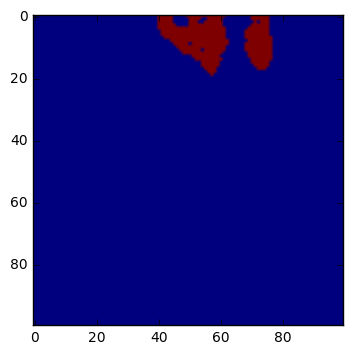

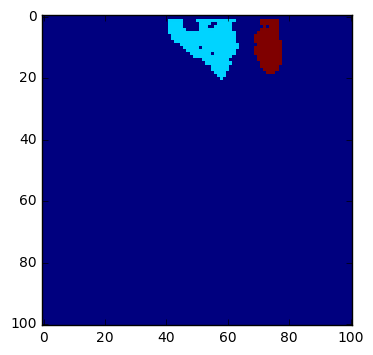

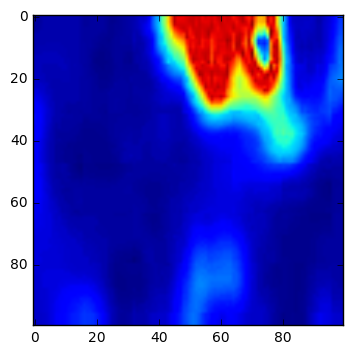

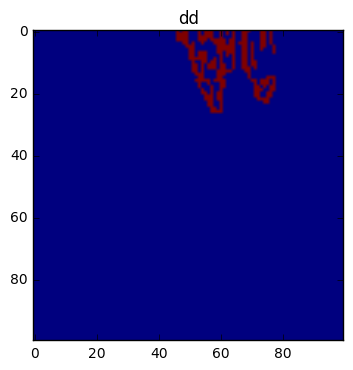

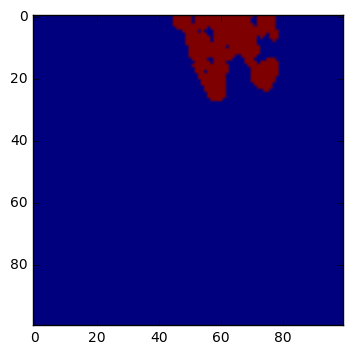

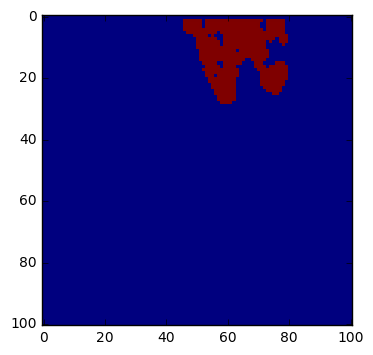

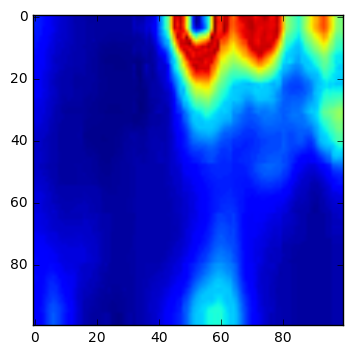

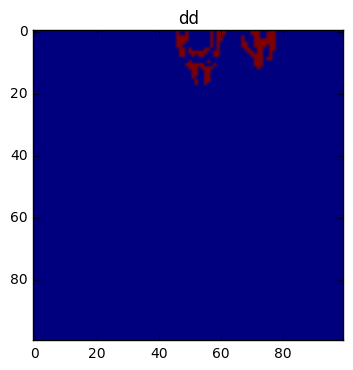

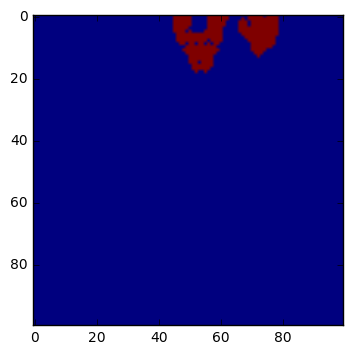

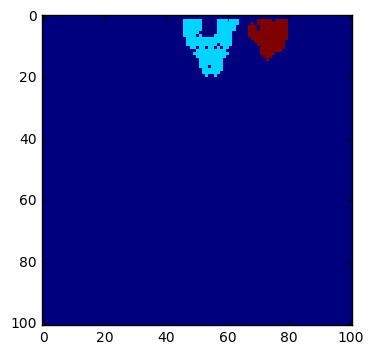

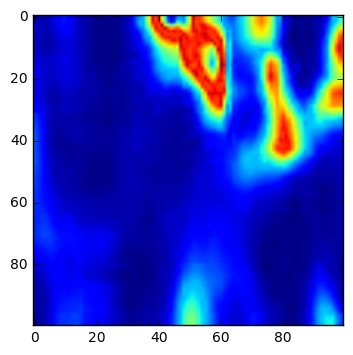

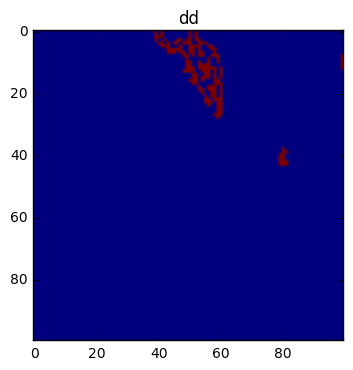

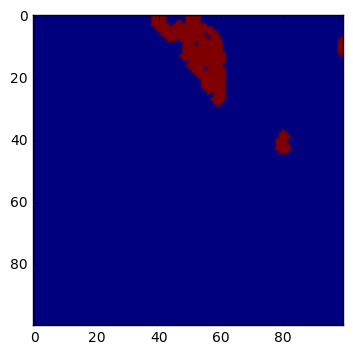

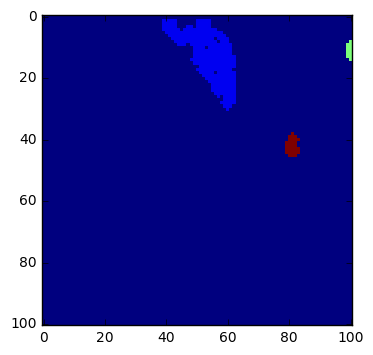

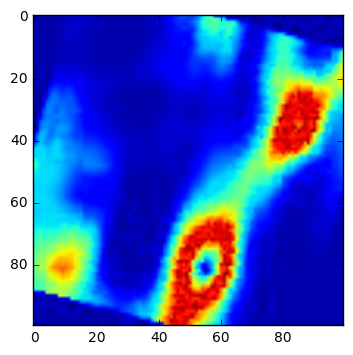

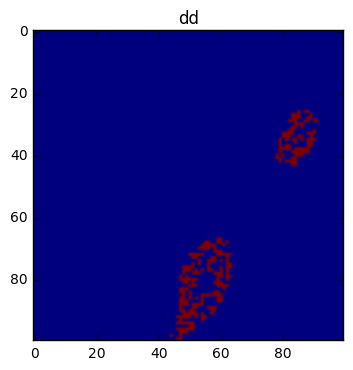

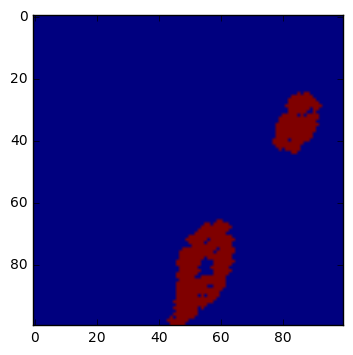

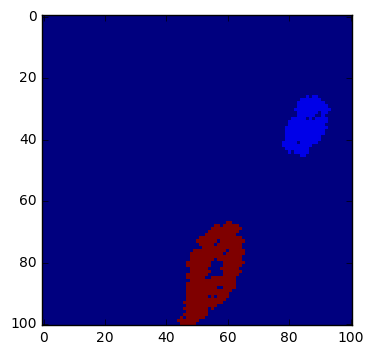

[[  40.            0.           64.           21.        ]
 [  42.90151515    0.           64.           16.37121212]
 [  68.            0.           78.           19.        ]
 [  68.57142857    0.           78.           18.88888889]
 [  45.            0.           80.           29.        ]
 [  46.62786596    0.           80.           23.08641975]
 [  45.            0.           64.           20.        ]
 [  45.            0.           63.4742268    17.24742268]
 [  66.            0.           80.           15.        ]
 [  67.088         0.           80.           12.368     ]
 [  38.            0.           63.           31.        ]
 [  44.31137725    0.           63.           25.10778443]
 [  98.            7.          101.           15.        ]
 [  98.16666667    7.          101.           15.        ]
 [  78.           37.           84.           46.        ]
 [  78.           37.93103448   83.86206897   46.        ]
 [  77.           25.           94.           46.       

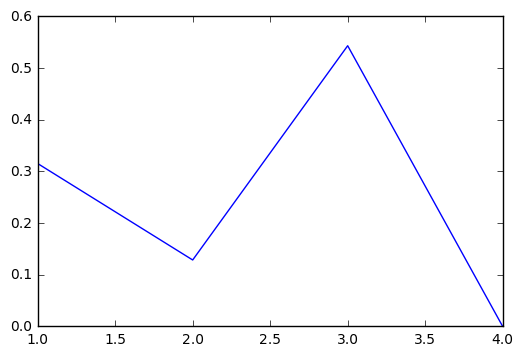

[3]
[array([ 51.37501558,   0.        ,  71.45618557,  20.67247732]), array([  43.40864198,   66.        ,   66.        ,  100.43333333]), array([ 84.36111111,  23.1698529 ,  92.94851408,  35.66666667])]


In [14]:
for i in range(N):
    rect_wrapper = detect_rects(final_data[i])
    (ks, Wks, Wkbs, sk,R) = get_best_rects(rect_wrapper)
    k = get_best_k(ks, Wks, Wkbs, sk)
    print(k+1)
    print(best_rects(R,k+1))